<a href="https://colab.research.google.com/github/tangmaomao16/single_mao_learns_single_cell/blob/main/scanpy/tutorial_01/pbmc3k_tang_20211023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.
    
The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [164]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2021-10-30 14:22:13--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-10-30 14:22:13--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  30.9MB/s    in 0.2s    

2021-10-30 14:22:13

<div class="alert alert-info">

**Note**
    
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

</div>  

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

</div>

要下载安装scanpy包

In [165]:
!pip install scanpy

In [166]:
import numpy as np
import pandas as pd
import scanpy as sc

In [167]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.2 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 pynndescent==0.5.5


In [168]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [`AnnData`](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5 file format: `.h5ad`.

In [169]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True
)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [170]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [171]:
adata
# observation是指观测，是指样本，在这里就是指细胞，总共有2700个细胞。
# variable是指变量，是指基因（的表达量），总共有32738种基因。

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


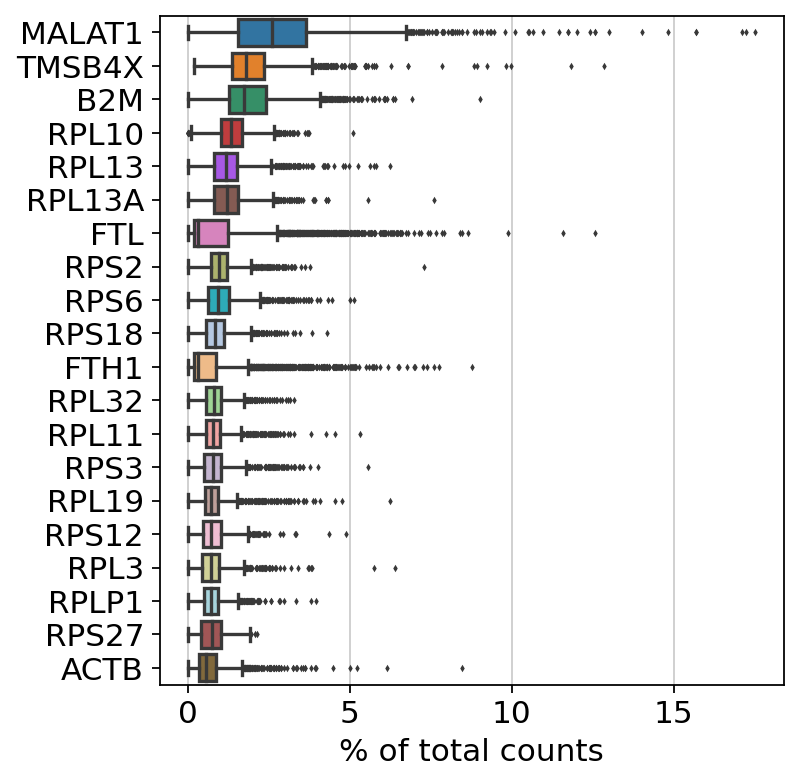

In [172]:
# sc表示scanpy，是一个包的名字
# pl表式plot作图
sc.pl.highest_expr_genes(adata, n_top=20, )
# 一个细胞中有3万种基因，把这3万种基因的表达量count值加起来，
# 然后用一种基因的表达量count值除以刚才的总表达量值，得到这个基因在这个细胞中的表达量比例值；
# 计算每一种基因在所有的细胞中的表达量占比的平均值，然后选取平均值最高的20种基因；
# 做盒须图展示每一种基因在所有细胞例如2700个细胞中各自的表达量的占比值。

Basic filtering:

In [173]:
# scanpy.preprocessing
# pp表示preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# 这种函数的效果是直接改变adata对象本身

# 名叫filter_cells()的函数，是对细胞做过滤操作，
# min_genes=200，表示一个细胞有表达的基因的种类数至少要有200种，少于200种基因的细胞会被过滤掉。

# 名叫filter_genes()的函数，是对基因做过滤操作，
# min_cells=3，表示一种基因至少要在3个细胞中有表达，少于3个细胞的基因会被过滤掉。

filtered out 19024 genes that are detected in less than 3 cells


In [174]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

线粒体基因含量的比例，会作为单细胞转录组测序数据质量好坏的一种表征。

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [175]:
adata.var

gene_ids  n_cells
AL627309.1     ENSG00000237683        9
AP006222.2     ENSG00000228463        3
RP11-206L10.2  ENSG00000228327        5
RP11-206L10.9  ENSG00000237491        3
LINC00115      ENSG00000225880       18
...                        ...      ...
AC145212.1     ENSG00000215750       16
AL592183.1     ENSG00000220023      323
AL354822.1     ENSG00000215615        8
PNRC2-1        ENSG00000215700      110
SRSF10-1       ENSG00000215699       69

[13714 rows x 2 columns]

In [176]:
adata.var['n_cells'].sum()

2282976

In [177]:
adata.var['n_cells'].max()
# adata.var['n_cells']中的某一个单元格的值的含义，应该是指，这一行对应的基因在多少个细胞中有表达。
# 最多在2700个细胞中有表达，也就是在所有的细胞中都有表达。

2700

In [178]:
adata.var_names
# 基因的英文简写名称

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [179]:
type(adata.var)
# adata.var是pandas的dataframe

pandas.core.frame.DataFrame

In [180]:
# var表示variable，在这里表示基因
# 在adata.var这个dataframe中新增加一列，单元格的值标注该行的基因的index即基因名是否以'MT-'开头，即是否为线粒体基因。
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt']


AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: mt, Length: 13714, dtype: bool

In [181]:
adata.obs

n_genes
AAACATACAACCAC-1      781
AAACATTGAGCTAC-1     1352
AAACATTGATCAGC-1     1131
AAACCGTGCTTCCG-1      960
AAACCGTGTATGCG-1      522
...                   ...
TTTCGAACTCTCAT-1     1155
TTTCTACTGAGGCA-1     1227
TTTCTACTTCCTCG-1      622
TTTGCATGAGAGGC-1      454
TTTGCATGCCTCAC-1      724

[2700 rows x 1 columns]

In [182]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
# qc_vars=['mt']，表示对adata.var['mt']做计算。

# percent_top=None 表示取百分之多少的表达量最高的基因做计算，这里为None，表示不做计算？
# Which proportions of top genes to cover. If empty or None don't calculate. Values are considered 1-indexed, percent_top=[50] finds cumulative proportion to the 50th most expressed gene.

# log1p : bool, optional (default: True) 某种转换计算
# Set to False to skip computing log1p transformed annotations.

# inplace : bool, optional (default: False) 计算出来的值会放到adata.obs或adata.var中，在这里会改变adata.obs，使得它多了几个列
#     Whether to place calculated metrics in adata's .obs and .var.

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

In [183]:
adata.var_names

Index(['AL627309.1', 'AP006222.2', 'RP11-206L10.2', 'RP11-206L10.9',
       'LINC00115', 'NOC2L', 'KLHL17', 'PLEKHN1', 'RP11-54O7.17', 'HES4',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'AC145212.1',
       'AL592183.1', 'AL354822.1', 'PNRC2-1', 'SRSF10-1'],
      dtype='object', length=13714)

In [184]:
?adata.obs

In [185]:
adata.obs
# 这是一个dataframe，里面有5列
# n_genes列中的一个单元格的数值表示，一个细胞中有多少个基因是有表达的。
# n_genes_by_counts列跟n_genes列的值很接近，但是n_genes_by_counts比n_genes略小一点，为什么？
# total_counts中的一个单元格的数值表示，一个细胞中所有基因的表达量count数之和。
# total_counts_mt中的一个单元格的数值表示，一个细胞中所有线粒体基因的表达量count数之和。
# pct_counts_mt中的一个单元格的数值表示，一个细胞中所有线粒体基因的表达量count数之和，占，这个细胞中所有基因的表达量count数之和，的比例值。

n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2700 rows x 5 columns]

In [186]:
adata.obs['total_counts_mt'] / adata.obs['total_counts'] * 100

AAACATACAACCAC-1    3.017776
AAACATTGAGCTAC-1    3.793596
AAACATTGATCAGC-1    0.889736
AAACCGTGCTTCCG-1    1.743085
AAACCGTGTATGCG-1    1.224490
                      ...   
TTTCGAACTCTCAT-1    2.110436
TTTCTACTGAGGCA-1    0.929422
TTTCTACTTCCTCG-1    2.197150
TTTGCATGAGAGGC-1    2.054795
TTTGCATGCCTCAC-1    0.806452
Length: 2700, dtype: float32

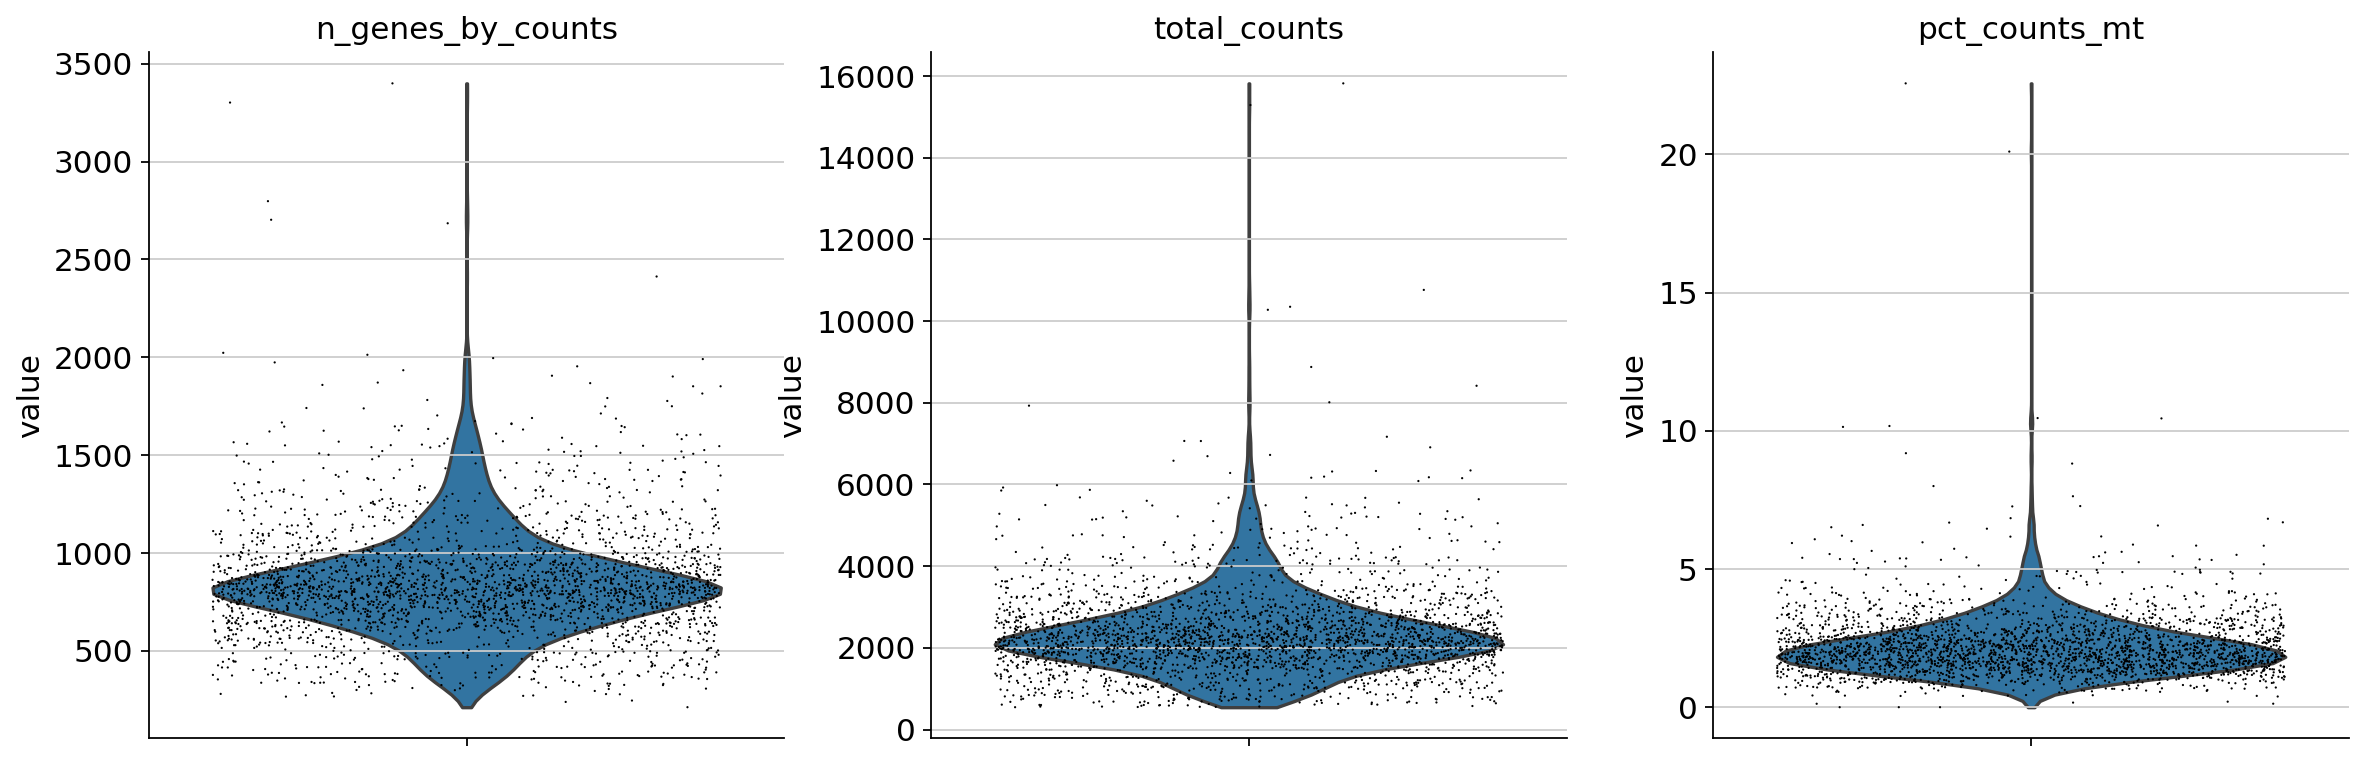

In [187]:
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, multi_panel=True
)

# keys : typing.Union[str, typing.Sequence[str]]，这里用的是adata.obs中的3个列的列名。
#     Keys for accessing variables of .var_names or fields of .obs.

# jitter : typing.Union[float, bool], optional (default: True) 
#     Add jitter to the stripplot (only when stripplot is True) See ~seaborn.stripplot.
# 应该是设置数据点的一个随机抖动离散的幅度，避免多个数据点完全重合，看不出来是多个数据点。

# multi_panel : typing.Union[bool, NoneType], optional (default: None)
#     Display keys in multiple panels also when groupby is not None.
# 这个参数的含义是，把['n_genes_by_counts', 'total_counts', 'pct_counts_mt']
# 这3个列的数据点分成多个小图来画，还是画在一个图中。

# 图中的每一个点代表一个细胞。
# 横轴没有数值意义。

# n_genes_by_counts图中，展示出来的结果是，比较多的细胞（点）它们的有表达的基因的种类数是1000种，
# 即大部分的细胞（点）有1000种有表达的基因。

# total_counts图中，展示出来的结果是，比较多的细胞（点）它们的各自的所有基因的总表达量counts为2000。

# pct_counts_mt图中，展示出来的结果是，比较多的细胞（点）它们的线粒体基因的含量为2.5%。

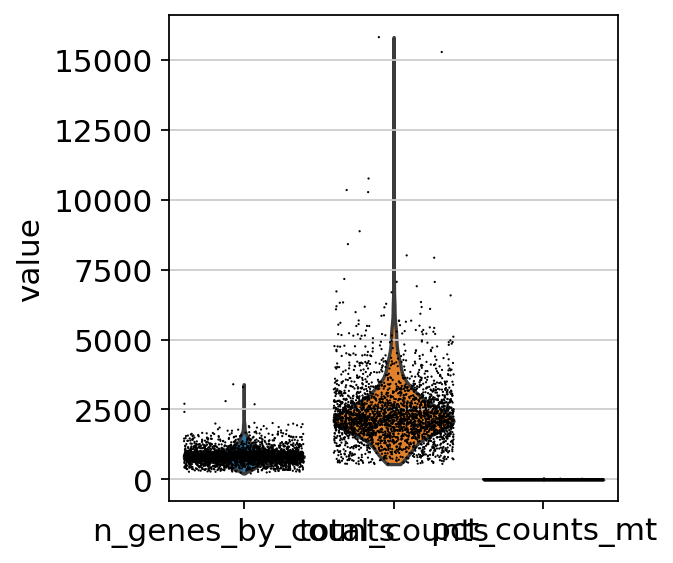

In [188]:
sc.pl.violin(
    adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
    jitter=0.4, 
    multi_panel=False
)
# 如果把multi_panel设置为False或None，默认值为None，那么就会把3种数值画在一个图中。
# 由于3种数值各自的取值范围差别很大，画在一个图中，则某一种数值的特征就不能展现出来，
# 特别是线粒体基因的比例值，它肯定比其他的counts值要小很多。

Remove cells that have too many mitochondrial genes expressed or too many total counts:

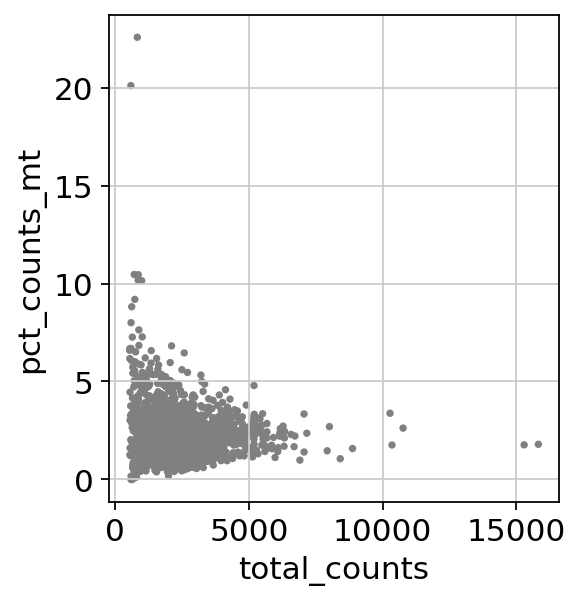

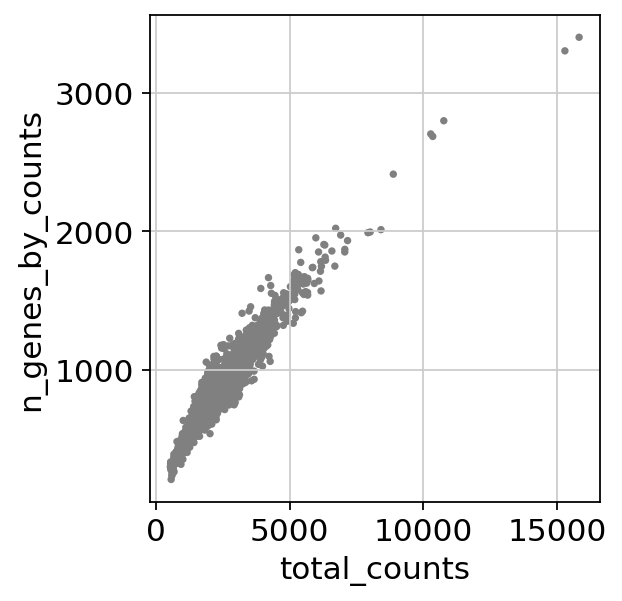

In [189]:
# sc.pl表示scanpy.plotting

# 线粒体基因的占比
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# 作图结果表明，线粒体基因的占比，不会随着一个细胞的总的基因的表达量的增多而上升。

# 有表达的基因的种类数
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
# 作图结果表明，有表达的基因的种类数，会随着一个细胞的总的基因的表达量的增多而增多。

Actually do the filtering by slicing the `AnnData` object.

把adata理解为是一个dataframe，里面的每一行代表一个细胞（observation），每一列代表一种基因（variable）。

In [190]:
adata.obs
# adata.obs是一个dataframe，里面的每一行代表一个细胞，
# 有5列: n_genes 	n_genes_by_counts 	total_counts 	total_counts_mt 	pct_counts_mt

n_genes  n_genes_by_counts  ...  total_counts_mt  pct_counts_mt
AAACATACAACCAC-1      781                779  ...             73.0       3.017776
AAACATTGAGCTAC-1     1352               1352  ...            186.0       3.793596
AAACATTGATCAGC-1     1131               1129  ...             28.0       0.889736
AAACCGTGCTTCCG-1      960                960  ...             46.0       1.743085
AAACCGTGTATGCG-1      522                521  ...             12.0       1.224490
...                   ...                ...  ...              ...            ...
TTTCGAACTCTCAT-1     1155               1153  ...             73.0       2.110436
TTTCTACTGAGGCA-1     1227               1224  ...             32.0       0.929422
TTTCTACTTCCTCG-1      622                622  ...             37.0       2.197150
TTTGCATGAGAGGC-1      454                452  ...             21.0       2.054795
TTTGCATGCCTCAC-1      724                723  ...             16.0       0.806452

[2700 rows x 5 columns]

In [191]:
# 从上面的作图来看，有表达的基因的种类数，在2500以上的，这样的细胞的个数很少，属于极端情况，
# 所以可以把这样的细胞的数据给剔除掉。
# 在写条件代码做处理时，是保留，有表达的基因的种类数，在2500以下的，这样的细胞的数据行。
adata = adata[adata.obs.n_genes_by_counts < 2500, :]

# 从上面的作图来看，线粒体基因的占比，在5%以上的，这样的细胞的个数很少，属于极端情况，
# 所以可以把这样的细胞的数据给剔除掉。
# 在写条件代码做处理时，是保留，线粒体基因的占比，在5%以下的，这样的细胞的数据行。
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

# 下面是追查normalize_total()函数的源代码在做什么处理

In [192]:
?sc.pp.normalize_total

In [193]:
from scanpy.get import _get_obs_rep, _set_obs_rep
# X = adata
# copy = True
# X = X.copy() if copy else X

adata_copy = adata.copy()
layer = None
X = _get_obs_rep(adata_copy, layer=layer)
X


<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [194]:
X.copy()

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

In [195]:
counts_per_cell = X.sum(1)
# X有第0个维度，第1个维度。
# 这里X.sum(1)，是在第1个维度上做sum加法，也就是把所有基因的数值给合到一起。
counts_per_cell
# 算出来每一个细胞各自的所有的基因的总表达量

matrix([[2419.],
        [4903.],
        [3147.],
        ...,
        [1684.],
        [1022.],
        [1984.]], dtype=float32)

In [196]:
np.shape(counts_per_cell)

(2638, 1)

In [197]:
counts_per_cell = np.ravel(counts_per_cell)
# ravel英文单词意思是"解开，拆开缠结在一起的东西"
# np.ravel()函数的作用是，把多维度（或称多层次）结构的array或matrix，展开，
# 变成只有1个维度的array。
counts_per_cell

array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [198]:
# inplace: bool = True,
# inplace = True
# if inplace:
#     if key_added is not None:
#         adata.obs[key_added] = counts_per_cell
#     _set_obs_rep(
#         adata, _normalize_data(X, counts_per_cell, target_sum), layer=layer
#     )

In [199]:
# def _normalize_data(X, counts, after=None, copy=False):
target_sum = 1e4
X = X
counts = counts_per_cell
after = target_sum
copy = False
X = X.copy() if copy else X

    # return X

In [200]:
if issubclass(X.dtype.type, (int, np.integer)):
    X = X.astype(np.float32)  # TODO: Check if float64 should be used


In [201]:
counts = np.asarray(counts)  # dask doesn't do medians
counts

array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [202]:
# 如果前面没有传参after=target_sum ，例如1e4，即10000
# 那么after变量的值则是，对所有细胞的总的基因表达量求中位数的值，
# 也就是处于中间水平的细胞的基因的总表达量是多少。
after = None # 默认值就是None
after = np.median(counts[counts > 0], axis=0) if after is None else after
after

2213.0

In [203]:
# 如果前面传参after=target_sum ，例如1e4，即10000,
# 那么after变量，会直接被赋值为target_sum的值
target_sum = 1e4
after = target_sum
after = np.median(counts[counts > 0], axis=0) if after is None else after
after

10000.0

无论有没有传参target_sum，对于所有的细胞来说，用的是同一个after值，不会说，对细胞001用一种after值，而对细胞002用另一种after值。

In [204]:
counts == 0

array([False, False, False, ..., False, False, False])

In [205]:
0 + (counts == 0)
# 这是为了查看，在做数学运算时，python会将False或True转成什么样的数值。
# False会转成0，True会转成1.
# counts不等于0的对应False，counts等于0的对应True。

array([0, 0, 0, ..., 0, 0, 0])

In [206]:
0 + np.array([False])

array([0])

In [207]:
0 + np.array([True])

array([1])

In [208]:
# 这个语句的含义是
# counts不等于0的则counts值保持不变，counts等于0的则counts值加1。
counts + (counts == 0)


array([2419., 4903., 3147., ..., 1684., 1022., 1984.], dtype=float32)

In [209]:
counts += counts == 0
# 等价于counts += (counts == 0)
# 等价于 counts = counts + (counts == 0)
# 因为默认输入数据counts值都是大于或等于0的，不存在负数，
# 所以经过这个语句的处理，counts值变成都是大于或等于1的，也就是说最小是1而不会是0.
# 可能是为了后面能当作分母，做除法运算。

# 总结就是，大于0的值保持不变，而等于0的值则变为1。


In [210]:
# counts += counts == 0
counts = counts / after
counts
# 先把counts缩小，变成小于1的小数。后面再除以这个小数，那么就会把值变大了。

array([0.2419, 0.4903, 0.3147, ..., 0.1684, 0.1022, 0.1984], dtype=float32)

In [211]:
from scipy.sparse import issparse
from sklearn.utils import sparsefuncs
if issparse(X):
    sparsefuncs.inplace_row_scale(X, 1 / counts)
else:
    np.divide(X, counts[:, None], out=X)

In [212]:
X

<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

# normalize_total()函数小结

我感觉这个sc.pp.normalize_total()标准化的处理，就是，每一个基因的表达量，除以，某一个细胞中的所有基因的总表达量，这算出来是一个比例值，也就是基因表达量的相对含量。（细节层面的话，有个遇到0则加1的处理，避免出现0值的情况）

那么对于一个细胞的各个基因的这些比例值，它们加起来，结果为1。对于所有的细胞，它们各自都是这样的。

由于这些比例值是小数，不够直观，或者不利于后面的运算处理。我们想把它们转化为大于1的数字，接近原来counts值的大小。所以我们会把这些比例值乘以一个固定的大的数字，例如10000，或1000000.这个固定的数字对所有细胞都是一样的。我们把这样的转化后的值称为normalized_counts值。

这样，每一个细胞的所有基因的normalized_counts值之和都相等，也就是细胞001的normalized_counts.sum()，细胞002的normalized_counts.sum()，细胞003的normalized_counts.sum()，，，它们都是相等的一个值。

# 对adata做标准化处理

In [213]:
# sc.pp表示scanpy.preprocessing
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Logarithmize the data:

In [214]:
# np.log1p(X, out=X)
# base的参数值默认为None,所以下面的if语句是不会执行的。
# if base is not None:
#     np.divide(X, np.log(base), out=X)

np.log1p()是numpy的函数，含义为log 1 plus x，即log(1+x), 默认底数为e=2.718.
可以写参数out来指定生成的结果保存到哪个变量中，一般可以用来表示对array做原位的改变操作。

In [215]:
X = np.array([1.0, 2.0, 3.0])
print(X)
print()
np.log1p(X, out=X)
print(X)

[1. 2. 3.]

[0.69314718 1.09861229 1.38629436]


### 对标准化后的表达量数值，做ln(1+x)的对数化处理

In [216]:
# 对标准化后的表达量数值，做ln(1+x)的对数化处理
sc.pp.log1p(adata)
# 为什么要做对数化处理呢？是为了让数值的范围缩小一些吗？

**做ln(1+x)处理，这一步很重要，在scanpy体系中必须做。**

因为下面的标注表达量高度变化的基因的函数，期望接受的数值，就是ln(1+x)的数值，而不是原始的数值。

在下面的标注表达量高度变化的基因的函数的代码内部，会对数值做指数运算，然后减一，求出count值。如果在这里不做ln(1+x)处理的话，那么在调用标注表达量高度变化的基因的函数时，得到的数值就不对了。

### 找出在不同的细胞中表达量的差别很大的基因

Expects logarithmized data, except when flavor='seurat_v3' in which count data is expected.
默认情况下，需要输入的数值是对数化处理后的数值。如果是flavor='seurat_v3',则要求输入的是count值，而不是对数化的值。

In [217]:
# hvg = _highly_variable_genes_single_batch(
#     adata_subset,
#     min_disp=min_disp,
#     max_disp=max_disp,
#     min_mean=min_mean,
#     max_mean=max_mean,
#     n_top_genes=n_top_genes,
#     n_bins=n_bins,
#     flavor=flavor,
# )

In [218]:
# mean, var = materialize_as_ndarray(_get_mean_var(X))
# 计算平均值和方差
# geneA的表达量在细胞001中有1个值，在细胞002中有1个值，在细胞003中有1个值，，，
# 计算geneA的表达量在所有细胞中的平均值，以及这些表达量数值的方差。

In [219]:
# def _get_mean_var(X, *, axis=0):
#     if sparse.issparse(X):
#         mean, var = sparse_mean_variance_axis(X, axis=axis)
#     else:
#         mean = np.mean(X, axis=axis, dtype=np.float64)
#         mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
#         var = mean_sq - mean ** 2
#     # enforce R convention (unbiased estimator) for variance
#     var *= X.shape[axis] / (X.shape[axis] - 1)
#     return mean, var

In [220]:
# mean, var = materialize_as_ndarray(_get_mean_var(X))

In [221]:
# n_top_genes : typing.Union[int, NoneType], optional (default: None)
#     Number of highly-variable genes to keep. Mandatory if flavor='seurat_v3'.

# min_mean : typing.Union[float, NoneType], optional (default: 0.0125)
    # If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# max_mean : typing.Union[float, NoneType], optional (default: 3)
#     If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# min_disp : typing.Union[float, NoneType], optional (default: 0.5)
#     If n_top_genes unequals None, this and all other cutoffs for the means and the normalized dispersions are ignored. Ignored if flavor='seurat_v3'.

# 深入学习highly_variable_genes()函数

highly_variable_genes()函数的作用是把表达量高度变化的基因给标注出来。

期望输入的adata，它里面是有对数化的数值的。
但是当flavor='seurat_v3'时，应该要用count数值，而不是对数化的数值。

对于Satija15和Zheng17的基于dispersion值的方法，标准化的dispersion值，是通过缩放dispersion的平均值和标准差，对那些落入一个给定箱子的基因，对于基因的平均表达量。这意味着，对于平均表达量的每一个箱子，表达量高度变化的基因会被选出来。
这段话我不懂？

而另一种方法是Stuart19的方法，对每一种基因计算标准化的方差值。
首先，用规范化的标准差对数据做标准化（即对每一个基因做z-score标准化）。
然后，计算上述标准化后的每一个基因的方差值，这个方差值就是标准化的方差值。
对基因按照方差值的大小来排序。

具体是怎么运算的，还得看源代码。

##

函数参数的描述


adata

虽然函数定义体的doc-string中说它是一个matrix，但是我查看adata的类型，它是一个anndata._core.anndata.AnnData对象。

#

layer

默认值是None。期望传入的参数值是字符串。

在不写这个参数时，函数会读取adata.X，来作为表达量数值。
如果写了这个参数值，那么函数会读取adata.layers[layer],来作为表达量数值。

#

n_top_genes

默认值是None。期望传入的参数值是一个int整数。

保留多少个表达量高度变化的基因，用来做下游的分析。
如果是flavor='seurat_v3'，那么这个参数是必须要写的。
如果写了n_top_genes参数，那么其它的一些cutoff条件会被视为无效。

后面会提到，函数设置的默认flavor是'seurat'。

#

min_mean

默认值是0.0125。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个min_mean参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个min_mean参数就会被视为无效。

#

max_mean

默认值是3。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个max_mean参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个max_mean参数就会被视为无效。

#

min_disp

默认值是0.5。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个min_disp参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个min_disp参数就会被视为无效。

#

max_disp

默认值是np.inf，即正无穷大。期望传入的参数值是一个float浮点数。

如果前面写了n_top_genes参数，那么这个max_disp参数就会被视为无效；如果是flavor='seurat_v3'，因为必须要写n_top_genes参数，所以这个max_disp参数就会被视为无效。

#

span

默认值是0.3。期望传入的参数值是一个float浮点数。

当flavor='seurat_v3时，用来估计loess拟合模型的方差值时，用多大比例的细胞的数据来做运算。

这个函数设置的flavor默认值是'seurat'，不是'seurat_v3'。

#

n_bins

默认值是20。期望传入的参数值是一个int整数。

对多个基因的平均表达量数值做分箱，设置用多少个箱子来做分箱。
标准化是对每一个箱子而言的。
如果一个箱子中只有1个基因落进去了，那么标准化的dispersion值会被强制写为1。
如果你设置了settings.verbosity=4,那么你会看到这样的被强制写为1的信息。

#

flavor

只能写这3个中的1个: 'seurat', 'cell_ranger', 'seurat_v3'。
默认值是'seurat'。

选择用哪种风格（或方式）来识别表达量高度变化的基因。对于基于dispersion值的方法来说，Seurat选择用cutoffs的方式来圈出表达量高度变化的基因，Cell Ranger用'n_top_genes'的方式来选出表达量高度变化的基因。

#

subset

默认值是False。期望传入的参数值是bool值。

如果写subset=True,那么就会对adata对象原位保留表达量高度变化的基因，把其它的基因给删掉。
如果写subset=False,那么就只是标注出来表达量高度变化的基因，不会删掉其它基因。默认值是False，即不会删掉其它基因。

#

inplace

默认值是True。期望传入的参数值是bool值。

如果写inplace=True,则会把计算出来的结果保存到adata.var成员中，var表示variable，即基因的数据。默认值是True。
如果写inplace=False,则不会把计算出来的结果保存到adata.var成员中，而是把计算出来的结果作为函数的返回值。

#

batch_key

默认值是None。期望传入的参数值是一个字符串。

如果写了这个参数，那么表达量高度变化的基因，会在每一个batch中分别被挑选出来，然后做合并。
这个简单的处理避免（或者说过滤掉了）batch-specific批次特异性的基因，可以看作是一个轻量级的batch correction method批次校正方法。
对于各种flavor，首先会对基因排序，根据基因在多少个batch中是表达量高度变化的基因。
对于基于dispersion的flavor，ties联系会被打断，由于标准化的dispersion。
对于seurat_ve的flavor，ties联系会被打断，由于批次内的标准化的方差值，做的跨越多个批次的中位数排序。这句话是啥意思？

#

check_values

默认值是True。期望传入的参数值是一个bool值。

只有当flavor='seurat_v3'时，才能做check_values。
就是检查在选择的layer中的counts值是不是整数。
什么叫layer?


##

highly_variable_genes()函数返回值的介绍

#

函数的返回值分2种情况，取决于inplace参数值。

默认情况下，inplace参数值为True，则函数会直接更新adata.var成员，具体增加或改变的是下面的field（或称列）：

**highly_variable**: 是一列bool值，True对应的基因为表达量高度变化的基因，False对应的基因则不是表达量高度变化的基因。

**dispersions**: 只有在基于dispersion的处理方式中，才有这一列的结果，是每一种基因的dispersion值。

**dispersions_norm**: 只有在基于dispersion的处理方式中，才有这一列的结果，是每一种基因的标准化的dispersion值。

**variances**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果，是每一种基因的表达量的方差值。

**variances_norm**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果，是每一种基因的表达量的标准化的方差值。如果是多个批次，则会取平均？这我看不懂。

**highly_variable_rank**: 只有在flavor='seurat_v3'的处理方式中，才有这一列的结果。根据标准化的方差值，对基因排序，基因的排序序号。如果是多个批次，则是用中位数排序方法？这我看不懂。

**highly_variable_nbatches**: 只有在写了batch_key参数后，才有这一列的结果。是一列整数，表示每一个基因，它们各自在多少个批次中被标注为表达量高度变化的基因。

**highly_variable_intersection**: 只有在写了batch_key参数后，才有这一列的结果。是一列bool值，表示每一个基因，它们各自是否在所有的批次中都被标注为表达量高度变化的基因。

##

注意，sc.pp.highly_variable_genes()函数已经取代了scanpy.pp.filter_genes_dispersion()，所以不要再使用scanpy.pp.filter_genes_dispersion()函数了。

### 下面学习sc.pp.highly_variable_genes()函数的定义体的源代码

In [222]:
n_top_genes = None,
min_disp = 0.5,
max_disp = np.inf,
min_mean = 0.0125,
max_mean = 3,

注意，在python中，给变量赋值时，后面不能加comma逗号。如果加了逗号，会变成tuple。

In [223]:
value_without_comma = None
value_with_comma = None,
print(value_without_comma)
print(value_without_comma is not None)
print(value_with_comma)
print(value_with_comma is not None)

None
False
(None,)
True


In [224]:
n_top_genes = None
min_disp = 0.5
max_disp = np.inf
min_mean = 0.0125
max_mean = 3

In [225]:
(m is None for m in [min_disp, max_disp, min_mean, max_mean])

<generator object <genexpr> at 0x7f325fd91e50>

In [226]:
generator_m_is_None = (m is None for m in [min_disp, max_disp, min_mean, max_mean])
for m_is_None in generator_m_is_None:
  print(m_is_None)

False
False
False
False


In [227]:
all([False,False,False,False])
# 判断是否iterable中的所有元素的值都为True，如果是则返回值为True；但凡有一个元素为False，则返回值为False.
# Return True if bool(x) is True for all values x in the iterable.
# If the iterable is empty, return True.

False

In [228]:
any([True, False, False])
# 判断iterable中的元素，是否有一个元素的值为True，如果有则返回值为True；但所有元素都为False，则返回值为False.
# Return True if bool(x) is True for any x in the iterable.
# If the iterable is empty, return False.

True

In [229]:
from .. import logging as logg

ImportError: ignored

### 找python模块文件在自己服务器中的路径

在学习python包的源代码时，如何复现导入相对路径的模块呢？

把相对路径，换成我自己的服务器中的绝对路径就好了。

问题变成了找，那个源代码.py文件，在我自己的服务器中的路径位置。

在colab中，对某个函数名单击“查看源代码”，右侧面板中，右键单击“路径”，就能获得该python模块文件在自己服务器中的路径。

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py

然后自己再思考一下，.点号表示的当前路径，其实是该python模块文件所在的目录路径，双点号..表示的路径，就是再向上一级的目录路径。

找到双点号..表示的路径对应的在服务器中的绝对路径后，思考如何能写出来有效的导入语句。

由于scanpy是能直接导入的，所以scanpy所在的目录，就是一个PYTHONPATH值的路径之一，也就是说是python会去scanpy所在的目录取搜索包名或模块名。
由于导入语句，是不能写含有/的路径的，只能写点号表示所属关系，所以我们需要把绝对路径换成导入语句能识别的内容。
最终就是把..换成scanpy就行了。

In [ ]:
# . = /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/
# .. = /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/..
# .. = /usr/local/lib/python3.7/dist-packages/scanpy/
# from .. import logging as logg
from scanpy import logging as logg
# /usr/local/lib/python3.7/dist-packages/scanpy/logging.py
# 可以看到logging是一个python文件，那么scanpy的作者在后面通过logg.info()的语句来调用logging.py文件中的函数或类。

In [ ]:
from /usr/local/lib/python3.7/dist-packages/scanpy/ import logging as logg

In [ ]:
!pwd

In [ ]:
# 通过这个代码的运行结果可以看到，logg.info()函数的功能，其实是打印信息，（另外还有其它的一些作用）。
n_top_genes = 100
if n_top_genes is not None and not all(
    m is None for m in [min_disp, max_disp, min_mean, max_mean]
):
    logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')
    print('If you pass `n_top_genes`, all cutoffs are ignored.')
n_top_genes = None

In [ ]:
# 我觉得在编程代码中，尽量使用“有"，“正向"，“正数"的语言，这样才好理解。
# 少用“没有"，“否定"的代码。
# 下面是我对scanpy的代码，改编后的代码
print(n_top_genes)
print(n_top_genes is not None)
if n_top_genes is not None and any(
    argument_value is not None
    for argument_value in [min_disp, max_disp, min_mean, max_mean]
 ):
  logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')
  # print('If you pass `n_top_genes`, all cutoffs are ignored.')

In [ ]:
# # 我觉得作者的意图是，当n_top_genes有值，而且[min_disp, max_disp, min_mean, max_mean]中至少有一个元素有值时，
# # 就打印提示信息，说你现在传入了n_top_genes参数值，那么其他的cutoff会被视作无效。
# if n_top_genes is not None and not all(
#     m is None for m in [min_disp, max_disp, min_mean, max_mean]
# ):
#     logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')

# # 用is None， is not None语句来判断，是因为默认值赋值为None了。

# # 在编程语言中，“有值"，只能用“不是空值"来表示。
# if n_top_genes is not None and any(
#     argument_value is not None
#     for argument_value in [min_disp, max_disp, min_mean, max_mean]
#  )

# if n_top_genes is not None and not all(
#     m is None for m in [min_disp, max_disp, min_mean, max_mean]
# ):
#     logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')



raise ValueError()语句。

程序运行，进入到raise ValueError语句内部，执行完之后，程序就会报错退出，不会执行后面的语句。

ValueError()括号里面，可以写多个字符串，中间可以有换行，程序会自动把这多个字符串给拼接为1个字符串，显示在报错信息中。

In [ ]:
print('sentence1')
if True:
  raise ValueError(
      'line1 in ValueError '
      'line2 in ValueError'
  )
print('sentence after raise ValueError')

### adata的成员的简介

In [ ]:
adata.X

In [ ]:
adata.obs

In [ ]:
type(adata.obs)

In [ ]:
adata.var

In [ ]:
type(adata.var)

In [ ]:
adata.uns

In [ ]:
type(adata.uns)

In [ ]:
adata.obs_names

In [ ]:
adata.var_names

In [ ]:
list_of_gene_names = ['AL627309.1', 'AP006222.2', 'RP11-206L10.2']
adata_subset = adata[:, list_of_gene_names]
print(adata_subset.obs)
print('####')
print(adata_subset.var)

https://github1s.com/theislab/scanpy/blob/HEAD/docs/usage-principles.rst#L40-L47

At the most basic level, an :class:`~anndata.AnnData` object `adata` stores
a data matrix `adata.X`, annotation of observations
`adata.obs` and variables `adata.var` as `pd.DataFrame` and unstructured
annotation `adata.uns` as `dict`. Names of observations and
variables can be accessed via `adata.obs_names` and `adata.var_names`,
respectively. :class:`~anndata.AnnData` objects can be sliced like
dataframes, for example, `adata_subset = adata[:, list_of_gene_names]`.
For more, see this `blog post`_

通常，我们把anndata.AnnData类的一个对象命名为或叫做adata，这个adata对象有一些成员或称属性。

**adata.X**: 保存的是一个表达量数值矩阵。是一种压缩格式的数据，Compressed Sparse Row format。

**adata.obs**: 保存的是细胞的observation观测记录，就是一个pandas.core.frame.DataFrame。里面的每一行代表一个细胞，列的话，有n_genes, 	n_genes_by_counts, 	total_counts 	total_counts_mt, 	pct_counts_mt, 这些信息。

**adata.var**: 保存的是基因（或称为variable变量，或属性）的数据，也是一个pandas.core.frame.DataFrame。里面的每一行代表一种基因，列的话，有gene_ids, n_cells, mt,	n_cells_by_counts, mean_counts, pct_dropout_by_counts , total_counts, 这些信息。

**adata.uns**: 保存的是unstructured annotation，非结构化的注释，是一个基于python dict的anndata.compat._overloaded_dict.OverloadedDict，这个类的定义体就不属于scanpy包了，而是anndata包的代码了。https://github1s.com/theislab/anndata/blob/HEAD/anndata/compat/_overloaded_dict.py#L72 这个源代码网页中有描述，但是我看不懂。

**adata.obs_names**: 保存的是adata.obs的row_index，即细胞名。

**adata.var_names**: 保存的是adata.var的row_index，即基因名。

**对adata对象可以用类似dataframe的中括号切片选取语法**: adata_subset = adata[:, list_of_gene_names]，在dataframe中，这样写表示选取所有的行，以及特定的列。在adata中，每一行代表一个细胞，每一列代表一种基因。所以这样写表示，选取所有的细胞，以及特定的基因。


In [ ]:
# 学习官方的函数的定义体
def highly_variable_genes(
    adata: AnnData,
    layer: Optional[str] = None,
    n_top_genes: Optional[int] = None,
    min_disp: Optional[float] = 0.5,
    max_disp: Optional[float] = np.inf,
    min_mean: Optional[float] = 0.0125,
    max_mean: Optional[float] = 3,
    span: Optional[float] = 0.3,
    n_bins: int = 20,
    flavor: Literal['seurat', 'cell_ranger', 'seurat_v3'] = 'seurat',
    subset: bool = False,
    inplace: bool = True,
    batch_key: Optional[str] = None,
    check_values: bool = True,
) -> Optional[pd.DataFrame]:

    # 检查是否传入了n_top_genes参数，是否会忽略其它cutoff参数。
    # 我觉得作者的意图是，当n_top_genes有值，而且[min_disp, max_disp, min_mean, max_mean]中至少有一个元素有值时，
    # 就打印提示信息，说你现在传入了n_top_genes参数值，那么其他的cutoff会被视作无效。
    # 如果用户的传参操作没有造成“其他的cutoff会被视作无效"的影响，那么是不需要打印这条提示信息的。
    if n_top_genes is not None and not all(
        m is None for m in [min_disp, max_disp, min_mean, max_mean]
    ):
        logg.info('If you pass `n_top_genes`, all cutoffs are ignored.')

    # 打印信息，说正在提取表达量高度变化的基因
    # logg.info()函数有自己特定的返回值
    start = logg.info('extracting highly variable genes')

    # 检查传入的adata参数值是不是一个AnnData类的对象
    # 如果不是一个AnnData类的对象，则会在屏幕上显示报错信息，退出程序。
    if not isinstance(adata, AnnData):
        raise ValueError(
            '`pp.highly_variable_genes` expects an `AnnData` argument, '
            'pass `inplace=False` if you want to return a `pd.DataFrame`.'
        )

    # flavor参数的默认值是'seurat'。
    # 如果用户传进来的flavor参数值为'seurat_v3'，
    # 那么就运行seurat_v3版本的标注表达量高度变化的基因的函数，
    # 然后结束这整个函数的程序。
    # 可以看到对seurat_v3版本的标注函数的传参过程中，确实没有传cutoff方面的参数。
    if flavor == 'seurat_v3':
      return _highly_variable_genes_seurat_v3(
          adata,
          layer=layer,
          n_top_genes=n_top_genes,
          batch_key=batch_key,
          check_values=check_values,
          span=span,
          subset=subset,
          inplace=inplace,
      )

    # 当flavor参数值不是'seurat_v3'，而是'seurat'或者'cell_ranger'时，
    # 才会运行下面的代码。

    # batch_key参数的默认值为None
    if batch_key is None:
      # 当用户不写batch_key参数时，就会调用_highly_variable_genes_single_batch()函数。
      # 从函数名来看，做的是1个批次的对表达量高度变化的基因的标注分析。
      # 也就是说，当用户不写batch_key参数时，就按照1个批次的来做分析。
      # 把函数的返回值保存到df中，看来返回值是一个dataframe。
      # 关键的一些数学计算过程应该要看这个函数的定义体。
      df = _highly_variable_genes_single_batch(
          adata,
          layer=layer,
          min_disp=min_disp,
          max_disp=max_disp,
          min_mean=min_mean,
          max_mean=max_mean,
          n_top_genes=n_top_genes,
          n_bins=n_bins,
          flavor=flavor,
      )
      # 这个df在后面会用到它，会取它其中的某些列赋值给其它的一些变量。

      # 代码中的有些地方，在colab中的右侧面板，不容易看出来一段代码究竟包括哪些行。
      # 我去github网站中看看，那里有代码区块显示功能。
      # 先找出想要查看的源代码文件在我自己的服务器中的绝对路径。然后去github网站找对应的文件夹、文件。
      # /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py
      # github网站中的网址
      # https://github.com/theislab/scanpy/blob/master/scanpy/preprocessing/_highly_variable_genes.py#L442
      # 我感觉github网站中对if else代码块也没有一个很好的显示。

      # 只能是把scanpy包下载到本地电脑，用VScode打开了。

      # 这篇知乎文章中，介绍了一种方法，可以用浏览器在线打开一个github仓库，
      # 以VScode网页版的形式来呈现代码文件内容。这样我才能单击折叠if else代码块，准确复制代码段落。
      # https://zhuanlan.zhihu.com/p/350897803 
      # 操作就是把原来的github仓库网址，在其中加入'1s'，复制粘贴到浏览器地址栏，就可以访问了。

      # https://github.com/theislab/scanpy
      # https://github1s.com/theislab/scanpy
      # 在里面也能像VScode那样，按住Ctrl，单击左键，跳转到变量定义处，但是这个有点慢，而且不一定能成功。
      # 要查看变量定义，还是在colab中，鼠标停留在变量处，选择查看源代码吧。

      # 这是另一种方法，但是对有的github仓库是不行的。不行啊，说这个仓库缺少json文件。
      # https://stackblitz.com/github.com/theislab/scanpy # 这是另一种方法，但是对有的github仓库是不行的。不行啊，说这个仓库缺少json文件。

    else:
        # 当用户写了batch_key参数时，则会执行下面的代码。
        # 其实可以先不学下面的代码，因为在初级教程中，没有写这个参数。

        # 我还学到一个python代码的知识点是，
        # 从package中导入__init__.py文件中的写着定义体的函数
        # from .._utils import sanitize_anndata, check_nonnegative_integers
        # _utils是一个文件夹的名字，并没有一个文件叫做_utils.py，
        # 而sanitize_anndata, check_nonnegative_integers函数的定义体
        # 在_utils文件夹中的__init__.py文件中，
        # 则在写导入语句的时候，就可以写从这个package中导入这2个函数，
        # python会自动从_utils文件夹中的__init__.py文件中查找这2个函数的定义体。

        # sanitize英文意思是消毒，使洁净。
        # """Transform string annotations to categoricals."""
        # 把字符串的注释，变成分类变量型的注释。
        sanitize_anndata(adata)
        batches = adata.obs[batch_key].cat.categories
        df = []
        gene_list = adata.var_names
        for batch in batches:
            adata_subset = adata[adata.obs[batch_key] == batch]

            # Filter to genes that are in the dataset
            with settings.verbosity.override(Verbosity.error):
                filt = filter_genes(adata_subset, min_cells=1, inplace=False)[0]

            adata_subset = adata_subset[:, filt]

            hvg = _highly_variable_genes_single_batch(
                adata_subset,
                min_disp=min_disp,
                max_disp=max_disp,
                min_mean=min_mean,
                max_mean=max_mean,
                n_top_genes=n_top_genes,
                n_bins=n_bins,
                flavor=flavor,
            )

            # Add 0 values for genes that were filtered out
            missing_hvg = pd.DataFrame(
                np.zeros((np.sum(~filt), len(hvg.columns))),
                columns=hvg.columns,
            )
            missing_hvg['highly_variable'] = missing_hvg['highly_variable'].astype(bool)
            missing_hvg['gene'] = gene_list[~filt]
            hvg['gene'] = adata_subset.var_names.values
            hvg = hvg.append(missing_hvg, ignore_index=True)

            # Order as before filtering
            idxs = np.concatenate((np.where(filt)[0], np.where(~filt)[0]))
            hvg = hvg.loc[np.argsort(idxs)]

            df.append(hvg)

        df = pd.concat(df, axis=0)
        df['highly_variable'] = df['highly_variable'].astype(int)
        df = df.groupby('gene').agg(
            dict(
                means=np.nanmean,
                dispersions=np.nanmean,
                dispersions_norm=np.nanmean,
                highly_variable=np.nansum,
            )
        )
        df.rename(
            columns=dict(highly_variable='highly_variable_nbatches'), inplace=True
        )
        df['highly_variable_intersection'] = df['highly_variable_nbatches'] == len(
            batches
        )

        if n_top_genes is not None:
            # sort genes by how often they selected as hvg within each batch and
            # break ties with normalized dispersion across batches
            df.sort_values(
                ['highly_variable_nbatches', 'dispersions_norm'],
                ascending=False,
                na_position='last',
                inplace=True,
            )
            df['highly_variable'] = False
            df.highly_variable.iloc[:n_top_genes] = True
            df = df.loc[adata.var_names]
        else:
            df = df.loc[adata.var_names]
            dispersion_norm = df.dispersions_norm.values
            dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
            gene_subset = np.logical_and.reduce(
                (
                    df.means > min_mean,
                    df.means < max_mean,
                    df.dispersions_norm > min_disp,
                    df.dispersions_norm < max_disp,
                )
            )
            df['highly_variable'] = gene_subset

    # 打印信息，说这个函数程序运行结束了。
    logg.info('    finished', time=start)

    # inplace默认值为True, subset默认值为False
    # 如果要改变adata本身，或者要过滤adata的数据，那么就执行下面的代码。
    # 默认情况下，是会运行下面的代码的。
    if inplace or subset:
        # 我还是看不懂这个adata.uns有什么用？
        adata.uns['hvg'] = {'flavor': flavor}

        logg.hint(
            'added\n'
            '    \'highly_variable\', boolean vector (adata.var)\n'
            '    \'means\', float vector (adata.var)\n'
            '    \'dispersions\', float vector (adata.var)\n'
            '    \'dispersions_norm\', float vector (adata.var)'
        )

        # df是前面的核新计算函数_highly_variable_genes_single_batch()的返回值。
        # 这里是把计算结果值，在adata.var（它是一个dataframe）中新增加对应的列，给保存起来。
        adata.var['highly_variable'] = df['highly_variable'].values
        adata.var['means'] = df['means'].values
        adata.var['dispersions'] = df['dispersions'].values
        adata.var['dispersions_norm'] = df['dispersions_norm'].values.astype(
            'float32', copy=False
        )
        # batch_key的默认值是None，所以不会执行下面的代码
        if batch_key is not None:
            adata.var['highly_variable_nbatches'] = df[
                'highly_variable_nbatches'
            ].values
            adata.var['highly_variable_intersection'] = df[
                'highly_variable_intersection'
            ].values
        # subset的默认值是False，所以不会执行下面的代码
        if subset:
            adata._inplace_subset_var(df['highly_variable'].values)
    else:
        # 如果进入下面的语句执行代码，那么就不会改变adata，而只是给出结果dataframe。
        return df
    


学习标注表达量高度变化的基因的核心计算代码

In [ ]:
# adata: AnnData,
layer = None
n_top_genes = None
min_disp = 0.5
max_disp = np.inf
min_mean = 0.0125
max_mean = 3
# span: Optional[float] = 0.3,
n_bins = 20
flavor = 'seurat'
# subset: bool = False,
# inplace: bool = True,
# batch_key: Optional[str] = None,
# check_values: bool = True,

# /usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py
from scanpy.preprocessing._highly_variable_genes import _highly_variable_genes_single_batch
df = _highly_variable_genes_single_batch(
    adata,
    layer=layer,
    min_disp=min_disp,
    max_disp=max_disp,
    min_mean=min_mean,
    max_mean=max_mean,
    n_top_genes=n_top_genes,
    n_bins=n_bins,
    flavor=flavor,
)

df

_highly_variable_genes_single_batch()函数的doc-string说，它的返回值是一个dataframe，含有`highly_variable`, `means`, `dispersions`, and `dispersions_norm`这4列的数值，但是我调用这个函数得到的dataframe还多了一列数值`mean_bin`。

In [ ]:
layer = None
X = adata.layers[layer] if layer is not None else adata.X
X

In [ ]:
adata.uns_keys()

In [ ]:
adata.uns['log1p']

In [ ]:
adata.uns['log1p']['base']

In [ ]:
np.e

In [ ]:
np.log(np.e)
# np.log()对数函数的底数默认值是np.e，即2.718

In [ ]:
np.exp(1)
# 计算e的若干次方等于多少。

In [163]:
np.expm1(np.array([1,2]))
# exp minus 1
# Calculate exp(x) - 1 for all elements in the array.
# 计算e的若干次方的值减一。

array([1.71828183, 6.3890561 ])

#### materialize_as_ndarray()

https://docs.dask.org/en/latest/

Dask: Dynamic task scheduling

是用来实现高效的并行计算的。

使用的语法类似numpy。

In [233]:
import dask.array as da
da

<module 'dask.array' from '/usr/local/lib/python3.7/dist-packages/dask/array/__init__.py'>

In [235]:
a = [1,2]
array_a = np.asarray(a)
print(array_a)
print(type(array_a))

# np.asarray这个函数的作用是把python的普通的list或tuple转变为numpy的array，即numpy.ndarray。
# Convert the input to an array.

# Input data, in any form that can be converted to an array. 
# This includes 
# lists, 
# lists of tuples, 
# tuples, 
# tuples of tuples, 
# tuples of lists 
# and ndarrays.

[1 2]
<class 'numpy.ndarray'>


In [237]:
a = [1,2]
type(a) in (list, tuple)
tuple(np.asarray(arr) for arr in a)

(array(1), array(2))

In [230]:
# /scanpy/preprocessing/_distributed.py

import numpy as np

# install dask if available
try:
    import dask.array as da
except ImportError:
    da = None


def materialize_as_ndarray(a):
  # 这个函数的作用是，如果传入的参数是一个python的普通的list或tuple，
  # 那么把它里面的元素各自转变为一个numpy.ndarray，然后返回值是这些numpy.ndarray构成的一个tuple,
  # 如果能用dask，那么就用dask做并行计算。
  # 如果传入的参数不是list或tuple，那么就把参数值转变为一个numpy.ndarray,作为返回值。
    """Convert distributed arrays to ndarrays.""" # 我不明白这句话的意思？
    if type(a) in (list, tuple):
        if da is not None and any(isinstance(arr, da.Array) for arr in a):
            return da.compute(*a, sync=True)
        return tuple(np.asarray(arr) for arr in a)
    return np.asarray(a)

#### _get_mean_var()函数

In [241]:
X = adata.layers[layer] if layer is not None else adata.X
X = np.expm1(X)
# print(X)
from scipy import sparse
print(sparse.issparse(X))
X

True


<2638x13714 sparse matrix of type '<class 'numpy.float32'>'
	with 2238732 stored elements in Compressed Sparse Row format>

numpy的axis


In [244]:
import numpy as np
 
#creating Numpy Array
np_array_2d = np.arange(0, 6).reshape([2,3])
 
print(np_array_2d)
print('####')
 
a = np.sum(np_array_2d, axis = 0)
print(a)
print('####')

b = np.sum(np_array_2d, axis = 1)
print(b)
print('####')

# 我感觉是0表示最里面的一层，1是往外的一层。

[[0 1 2]
 [3 4 5]]
####
[3 5 7]
####
[ 3 12]
####


In [250]:
np.asarray( ([1]*9,[2]*9,[3]*9) ).reshape([3,3,3])

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]])

In [254]:
np_array_3d = np.asarray(
  [
    [
      [1, 1, 1],
      [2, 2, 2],
      [3, 3, 3]
    ],
    [
      [4, 4, 4],
      [5, 5, 5],
      [6, 6, 6]
    ],
    [
      [7, 7, 7],
      [8, 8, 8],
      [9, 9, 9]
    ],
  ]
)

In [257]:
np.add.reduce

<function ufunc.reduce>

In [255]:
import numpy as np
 
#creating Numpy Array
# np_array_3d = np.asarray( ([1]*9,[2]*9,[3]*9) ).reshape([3,3,3])
 
print(np_array_3d)
print('####')

axis_a = 0 
print(axis_a)
a = np.sum(np_array_3d, axis = axis_a)
print(a)
print('####')

axis_b = 1 
print(axis_b)
b = np.sum(np_array_3d, axis = axis_b)
print(b)
print('####')

axis_c = 2
print(axis_c)
c = np.sum(np_array_3d, axis = axis_c)
print(c)
print('####')

[[[1 1 1]
  [2 2 2]
  [3 3 3]]

 [[4 4 4]
  [5 5 5]
  [6 6 6]]

 [[7 7 7]
  [8 8 8]
  [9 9 9]]]
####
0
[[12 12 12]
 [15 15 15]
 [18 18 18]]
####
1
[[ 6  6  6]
 [15 15 15]
 [24 24 24]]
####
2
[[ 3  6  9]
 [12 15 18]
 [21 24 27]]
####


关于numpy中的沿着axis计算的介绍，有一篇知乎帖子写得很好。

https://zhuanlan.zhihu.com/p/31275071

我这里要总结的是，axis=0是指最外层的容器，axis=1是向里一层的容器，axis=2是再向里一层的容器。

在图形，形象化思考方面，要用外到内的容器的思维方式去想象。
在底层运算时，要用C++编程语言的多维数组的方式去做计算。

当选定沿着某一个维度做计算时，它的底层代码含义是，这一个维度的下标（或称索引号）会发生变化，可以理解为是做一种for循环时，递增的i或index，要用C++编程语言的多维数组去理解。我发现numpy.ndarray，也能用多维数组取值的语法，例如arrray_a[0][0][0]。

例如做sum求和运算，起始array是a,它里面有a[0][0][0]到a[2][1][3]总共`3*2*4=24`个数字,指定axis=1，这时候，首先要确定结果result_array的shape形状,相当于是消掉第1维，留下剩下的维(即原来的第0维和第2维)，应该变成了[3,4]这样的形状。然后我们就去计算这里面的每一个位置的元素的值，分别求

result_array[0][0],result_array[0][1],result_array[0][2],result_array[0][3];

result_array[1][0],result_array[1][1],result_array[1][2],result_array[1][3];

result_array[2][0],result_array[2][1],result_array[2][2],result_array[2][3]。

每一个位置的元素的求法是
result_array[0][0] = calculate_changing_index_in_that_axis__fix_other_axis(a)

即result_array[0][0] = a[0][0][0] + a[0][1][0]

##

再总结一下计算，先确定结果result_array的shape，（就是把指定的axis给消掉，剩下来的结构），然后求每一个位置的元素的值；在求某一个位置的元素的值时，固定起始array多维数组中其它维的索引号下标，变化指定的axis维的索引和下标，遍历这一维的索引号下标，完成运算。

In [258]:
array_3_2_4 = np.asarray(
    [
     [
      [1,2,3,4],
      [1,3,4,5]
     ],
     [
      [2,4,7,5],
      [8,4,3,5]
     ],
     [
      [2,5,7,3],
      [1,5,3,7]
     ],
    ]
)

In [260]:
np.sum(array_3_2_4, axis=1)
[
  [2,  5,  7,  9],
  [10,  8, 10, 10],
  [3, 10, 10, 10]
]

[[2, 5, 7, 9], [10, 8, 10, 10], [3, 10, 10, 10]]

In [261]:
a = array_3_2_4
a[0][0][0]

1

In [263]:
a[0][0][0] + a[0][1][0]

2

In [264]:
a[1][0][0] + a[1][1][0]

10

In [265]:
result_array = np.zeros(shape=[3,4])
result_array

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [266]:
result_array[0][0] = a[0][0][0] + a[0][1][0]
result_array[0][0]

2.0

In [267]:
result_array[0][0] = a[0][0][0] + a[0][1][0]
result_array[0][1] = a[0][0][1] + a[0][1][1]
result_array[0][2] = a[0][0][2] + a[0][1][2]
result_array[0][3] = a[0][0][3] + a[0][1][3]
result_array

array([[2., 5., 7., 9.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
# /scanpy/preprocessing/_utils.py

import numpy as np
from scipy import sparse
import numba

def sparse_mean_variance_axis(mtx: sparse.spmatrix, axis: int):
    """
    This code and internal functions are based on sklearns
    `sparsefuncs.mean_variance_axis`.

    Modifications:
    * allow deciding on the output type, 
      which can increase accuracy when calculating the mean and variance of 32bit floats.
    * This doesn't currently implement support for null values, but could.
    * Uses numba not cython
    """
    assert axis in (0, 1)
    if isinstance(mtx, sparse.csr_matrix):
        ax_minor = 1
        shape = mtx.shape
    elif isinstance(mtx, sparse.csc_matrix):
        ax_minor = 0
        shape = mtx.shape[::-1]
    else:
        raise ValueError("This function only works on sparse csr and csc matrices")
    if axis == ax_minor:
        return sparse_mean_var_major_axis(
            mtx.data, mtx.indices, mtx.indptr, *shape, np.float64
        )
    else:
        return sparse_mean_var_minor_axis(mtx.data, mtx.indices, *shape, np.float64)

def _get_mean_var(X, *, axis=0):
    if sparse.issparse(X):
        # 默认情况下，X是Compressed Sparse Row format，
        # 所以会执行这里的代码
        # 这里是计算平均值和方差。
        # 由于输入的数据是Compressed Sparse Row format，所以要调用相应的适用的函数去计算。
        mean, var = sparse_mean_variance_axis(X, axis=axis)
    else:
        # 不是默认情况时，则用普通的numpy函数计算平均值和方差值
        mean = np.mean(X, axis=axis, dtype=np.float64)
        # 计算方差，最好查一下数学公式，这里应该是用了便于计算的那个公式。
        # 还有axis=0,是指从外到里，还是从里到外的第1层？ 20211031 0：30 我理解了axis的含义
        mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)
        var = mean_sq - mean ** 2
    # enforce R convention (unbiased estimator) for variance
    # 这里应该是估算总体的方差值。前面算出来的是样本的方差值。
    var *= X.shape[axis] / (X.shape[axis] - 1)
    return mean, var

In [ ]:
def _highly_variable_genes_single_batch(
    adata: AnnData,
    layer: Optional[str] = None,
    min_disp: Optional[float] = 0.5,
    max_disp: Optional[float] = np.inf,
    min_mean: Optional[float] = 0.0125,
    max_mean: Optional[float] = 3,
    n_top_genes: Optional[int] = None,
    n_bins: int = 20,
    flavor: Literal['seurat', 'cell_ranger'] = 'seurat',
) -> pd.DataFrame:
    """\
    See `highly_variable_genes`.

    Returns
    -------
    A DataFrame that contains the columns
    `highly_variable`, `means`, `dispersions`, and `dispersions_norm`.
    """
    # layer的默认值为None，所以会把adata.X赋值给变量X，adata.X是一种压缩格式的表达量矩阵。
    X = adata.layers[layer] if layer is not None else adata.X

    # flavor的默认值是'seurat'，所以会执行下面的代码。
    # 主要目的是获得count值
    if flavor == 'seurat':
        # 默认情况下，adata.uns_keys()中有'log1p'，
        # adata.uns['log1p']['base']为None.
        # 也就是说当有log1plusX函数时，而且有明确的对数的底数时，就用这个底数来做运算，
        # 但是我看不懂这里写的运算是等同于ln(1+X)吗？
        # 由于默认情况下，没有明确的对数的底数，所以是不执行这个代码的。
        if 'log1p' in adata.uns_keys() and adata.uns['log1p']['base'] is not None:
            X *= np.log(adata.uns['log1p']['base'])
            # X = X * np.log(adata.uns['log1p']['base'])

        # 前面的X 是ln(1+count)算出来的，
        # 现在把X做e的X次方运算得到1+count，然后减一得到count值。
        X = np.expm1(X)

    mean, var = materialize_as_ndarray(_get_mean_var(X))
    # now actually compute the dispersion
    mean[mean == 0] = 1e-12  # set entries equal to zero to small value
    dispersion = var / mean
    if flavor == 'seurat':  # logarithmized mean as in Seurat
        dispersion[dispersion == 0] = np.nan
        dispersion = np.log(dispersion)
        mean = np.log1p(mean)
    # all of the following quantities are "per-gene" here
    df = pd.DataFrame()
    df['means'] = mean
    df['dispersions'] = dispersion
    if flavor == 'seurat':
        df['mean_bin'] = pd.cut(df['means'], bins=n_bins)
        disp_grouped = df.groupby('mean_bin')['dispersions']
        disp_mean_bin = disp_grouped.mean()
        disp_std_bin = disp_grouped.std(ddof=1)
        # retrieve those genes that have nan std, these are the ones where
        # only a single gene fell in the bin and implicitly set them to have
        # a normalized disperion of 1
        one_gene_per_bin = disp_std_bin.isnull()
        gen_indices = np.where(one_gene_per_bin[df['mean_bin'].values])[0].tolist()
        if len(gen_indices) > 0:
            logg.debug(
                f'Gene indices {gen_indices} fell into a single bin: their '
                'normalized dispersion was set to 1.\n    '
                'Decreasing `n_bins` will likely avoid this effect.'
            )
        # Circumvent pandas 0.23 bug. Both sides of the assignment have dtype==float32,
        # but there’s still a dtype error without “.value”.
        disp_std_bin[one_gene_per_bin.values] = disp_mean_bin[
            one_gene_per_bin.values
        ].values
        disp_mean_bin[one_gene_per_bin.values] = 0
        # actually do the normalization
        df['dispersions_norm'] = (
            df['dispersions'].values  # use values here as index differs
            - disp_mean_bin[df['mean_bin'].values].values
        ) / disp_std_bin[df['mean_bin'].values].values
    elif flavor == 'cell_ranger':
        from statsmodels import robust

        df['mean_bin'] = pd.cut(
            df['means'],
            np.r_[-np.inf, np.percentile(df['means'], np.arange(10, 105, 5)), np.inf],
        )
        disp_grouped = df.groupby('mean_bin')['dispersions']
        disp_median_bin = disp_grouped.median()
        # the next line raises the warning: "Mean of empty slice"
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disp_mad_bin = disp_grouped.apply(robust.mad)
            df['dispersions_norm'] = (
                df['dispersions'].values - disp_median_bin[df['mean_bin'].values].values
            ) / disp_mad_bin[df['mean_bin'].values].values
    else:
        raise ValueError('`flavor` needs to be "seurat" or "cell_ranger"')
    dispersion_norm = df['dispersions_norm'].values
    if n_top_genes is not None:
        dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
        dispersion_norm[
            ::-1
        ].sort()  # interestingly, np.argpartition is slightly slower
        if n_top_genes > adata.n_vars:
            logg.info('`n_top_genes` > `adata.n_var`, returning all genes.')
            n_top_genes = adata.n_vars
        disp_cut_off = dispersion_norm[n_top_genes - 1]
        gene_subset = np.nan_to_num(df['dispersions_norm'].values) >= disp_cut_off
        logg.debug(
            f'the {n_top_genes} top genes correspond to a '
            f'normalized dispersion cutoff of {disp_cut_off}'
        )
    else:
        dispersion_norm[np.isnan(dispersion_norm)] = 0  # similar to Seurat
        gene_subset = np.logical_and.reduce(
            (
                mean > min_mean,
                mean < max_mean,
                dispersion_norm > min_disp,
                dispersion_norm < max_disp,
            )
        )

    df['highly_variable'] = gene_subset
    return df


In [59]:
type(adata)

anndata._core.anndata.AnnData

In [61]:
# scanpy.preprocessing
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 这几个参数是什么意思？
# 我感觉它们的意思是，只有满足条件，表达量平均值，在0.0125到3之间的，dispersion值不能小于0.5的，
# 这些基因才有可能被标注为表达量高度变化的基因，才被拿去做下游的降维分析。

# Annotate highly variable genes
# 这个函数的作用是对在不同的细胞中的表达量变化很大的基因作标注。

# **means**
#     means per gene


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


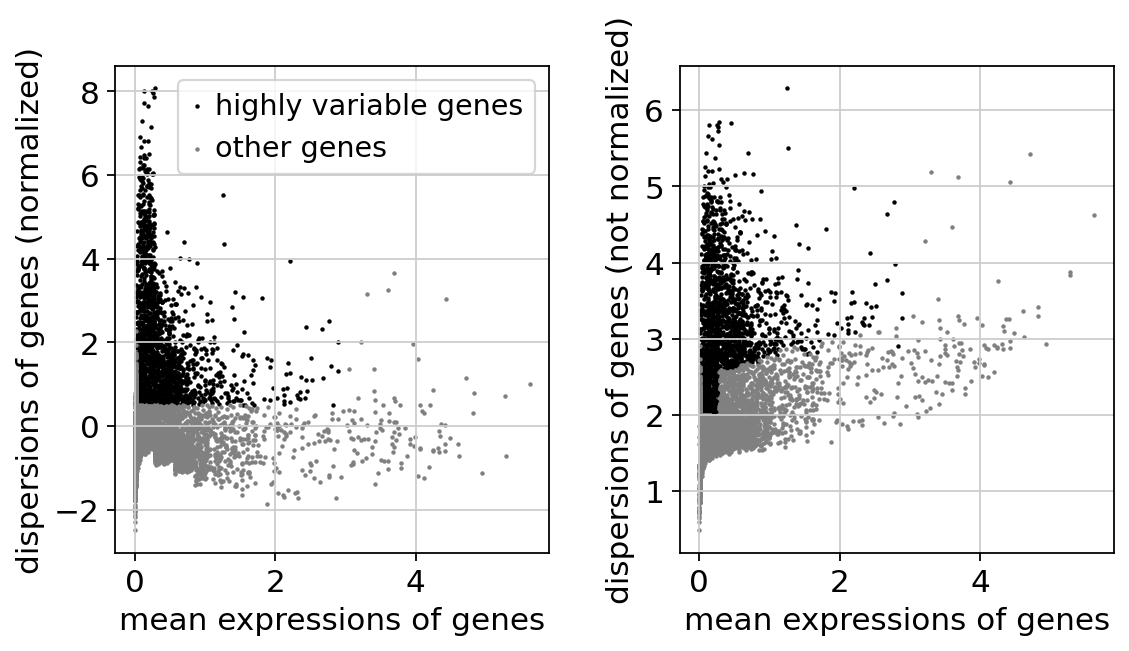

In [62]:
# scanpy.plotting
sc.pl.highly_variable_genes(adata)
# 我对这个图的理解是
# 每一个点代表一种基因，
# 横坐标的值表示这一种基因在所有细胞中的表达量的平均值，
# 纵坐标的值表示这一种基因在所有细胞中的表达量的离散程度dispersion。
# dispersion和variance方差是一回事吗？是两个东西。

# 在_highly_variable_genes_single_batch()函数的定义体中，
# dispersion等于方差除以平均值，也就是说这算出来的是一种相对离散程度，
# 因为一般情况中，平均值越大的，算出来的方差的绝对值也会越大，
# 为了抵消这种影响，于是对方差除以平均值。
    # # now actually compute the dispersion
    # mean[mean == 0] = 1e-12  # set entries equal to zero to small value
    # dispersion = var / mean

# normalized 的图中为什么，dispersion值会有负数呢？
# 它这个normalized是指center化吗，那平均值也是0啊？

# 这里的normalized和not normalized是指前面的计算相对含量的标准化操作，
# 还是这里的highly_variable_genes()函数内部做了什么新的标准化操作？

# Plot dispersions or normalized variance versus means for genes.
# Produces Supp. Fig. 5c of Zheng et al. (2017) and MeanVarPlot() and VariableFeaturePlot() of Seurat.

# 这2个函数确实不懂。

In [65]:
# gene_subset = adata.highly_variable
# gene_subset
from anndata import AnnData
isinstance(adata, AnnData)


True

In [66]:
# adata.var表示variable，而不是variance方差
result = adata.var
result

gene_ids  n_cells  ...  dispersions  dispersions_norm
AL627309.1     ENSG00000237683        9  ...     1.432845         -0.624328
AP006222.2     ENSG00000228463        3  ...     1.458631         -0.573416
RP11-206L10.2  ENSG00000228327        5  ...     1.325459         -0.836359
RP11-206L10.9  ENSG00000237491        3  ...     0.859264         -1.756848
LINC00115      ENSG00000225880       18  ...     1.457477         -0.575693
...                        ...      ...  ...          ...               ...
AC145212.1     ENSG00000215750       16  ...     1.784637          0.070275
AL592183.1     ENSG00000220023      323  ...     1.859941         -0.437388
AL354822.1     ENSG00000215615        8  ...     1.781924          0.064919
PNRC2-1        ENSG00000215700      110  ...     1.567491         -0.358474
SRSF10-1       ENSG00000215699       69  ...     1.544864         -0.403150

[13714 rows x 11 columns]

In [67]:
gene_subset = result.highly_variable
gene_subset
# adata.var.highly_variable 存的是每一个基因是不是highly_variable的bool值

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [70]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [68]:
means = result.means
means
# adata.means 存的是每一个基因在所有细胞中表达量的平均值

AL627309.1       0.013556
AP006222.2       0.004696
RP11-206L10.2    0.005673
RP11-206L10.9    0.002644
LINC00115        0.027437
                   ...   
AC145212.1       0.027441
AL592183.1       0.485051
AL354822.1       0.012157
PNRC2-1          0.160366
SRSF10-1         0.100255
Name: means, Length: 13714, dtype: float64

In [69]:
max(means)

5.622219057802739

In [72]:
seurat_v3_flavor = adata.uns["hvg"]["flavor"] == "seurat_v3"
seurat_v3_flavor
# 这个adata不是seurat_v3_flavor

False

In [73]:
var_or_disp = result.dispersions
var_or_disp


AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325459
RP11-206L10.9    0.859264
LINC00115        1.457477
                   ...   
AC145212.1       1.784637
AL592183.1       1.859941
AL354822.1       1.781924
PNRC2-1          1.567491
SRSF10-1         1.544864
Name: dispersions, Length: 13714, dtype: float64

In [75]:
var_or_disp_norm = result.dispersions_norm
var_or_disp_norm
# 我不知道dispersion是如何做标准化的。
# 具体的过程要看上一个计算函数的源代码。

AL627309.1      -0.624328
AP006222.2      -0.573416
RP11-206L10.2   -0.836359
RP11-206L10.9   -1.756848
LINC00115       -0.575693
                   ...   
AC145212.1       0.070275
AL592183.1      -0.437388
AL354822.1       0.064919
PNRC2-1         -0.358474
SRSF10-1        -0.403150
Name: dispersions_norm, Length: 13714, dtype: float32

In [76]:
gene_subset # 保存的内容是每一个基因是否为highly varialbe gene的bool值

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

In [77]:
# 前面加一个上波浪线是对bool值取反的意思
~gene_subset 

AL627309.1       True
AP006222.2       True
RP11-206L10.2    True
RP11-206L10.9    True
LINC00115        True
                 ... 
AC145212.1       True
AL592183.1       True
AL354822.1       True
PNRC2-1          True
SRSF10-1         True
Name: highly_variable, Length: 13714, dtype: bool

In [78]:
zip_result = zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  )
zip_result

highly variable genes; black; AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool
other genes; grey; AL627309.1       True
AP006222.2       True
RP11-206L10.2    True
RP11-206L10.9    True
LINC00115        True
                 ... 
AC145212.1       True
AL592183.1       True
AL354822.1       True
PNRC2-1          True
SRSF10-1         True
Name: highly_variable, Length: 13714, dtype: bool


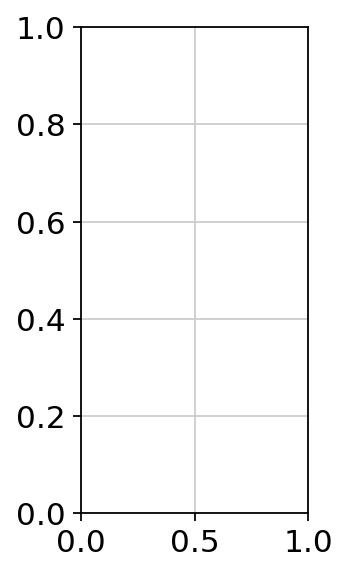

In [82]:
from matplotlib import pyplot as pl

idx = 0
pl.subplot(1, 2, idx + 1)

zip_result = zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  )

for label, color, mask in zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
  ):
  print(f"{label}; {color}; {mask}")

In [84]:
for label, color, mask in zip(
    ['highly variable genes', 'other genes'],
    ['black', 'grey'],
    [gene_subset, ~gene_subset],
):
    if False:
        means_, var_or_disps_ = np.log10(means[mask]), np.log10(d[mask])
    else:
        means_, var_or_disps_ = means[mask], var_or_disp_norm[mask]
        print(means_, var_or_disp)

TNFRSF4    0.277410
CPSF3L     0.385194
ATAD3C     0.038252
C1orf86    0.678283
RER1       0.814813
             ...   
ICOSLG     0.082016
SUMO3      0.804815
SLC19A1    0.058960
S100B      0.286282
PRMT2      0.816647
Name: means, Length: 1838, dtype: float64 AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325459
RP11-206L10.9    0.859264
LINC00115        1.457477
                   ...   
AC145212.1       1.784637
AL592183.1       1.859941
AL354822.1       1.781924
PNRC2-1          1.567491
SRSF10-1         1.544864
Name: dispersions, Length: 13714, dtype: float64
AL627309.1       0.013556
AP006222.2       0.004696
RP11-206L10.2    0.005673
RP11-206L10.9    0.002644
LINC00115        0.027437
                   ...   
AC145212.1       0.027441
AL592183.1       0.485051
AL354822.1       0.012157
PNRC2-1          0.160366
SRSF10-1         0.100255
Name: means, Length: 11876, dtype: float64 AL627309.1       1.432845
AP006222.2       1.458631
RP11-206L10.2    1.325

总结一下，sc.pl.highly_variable_genes(adata)作图代码做的事，总共会作2个图。

第1个图，把adata中的每一个基因在所有细胞中的平均值，以及标准化的dispersion值取出来，以及哪些基因是highly variable gene的信息取出来，做散点图，每一个点代表一个基因，横坐标是基因的表达量的平均值，纵坐标是标准化的dispersion值，然后给是highly variable gene的点涂黑色，给不是highly variable gene的点涂灰色。

第2个图，只是把上面的标准化的dispersion值换成了没做标准化的dispersion值，其它的数据信息以及画图做法都一样。

##

引出的问题是，前面计算highly variable gene时，是怎么判断一个基因是否为highly variable gene的？dispersion值的标准化，是怎么做的？
需要看源代码。

##

到底是否需要做剔除高度变化的表达量的基因这种操作？我看晶能生物公司的分析报告中没有这个操作。

还有就是这个步骤有没有做剔除，还是只是把这些基因给找出来？

https://www.embopress.org/doi/full/10.15252/msb.20188746

Current best practices in single-cell RNA-seq analysis: a tutorial

看一下这篇文献是怎么介绍的。

For example, barcodes with a low count depth, few detected genes, and a high fraction of mitochondrial counts are indicative of cells whose cytoplasmic mRNA has leaked out through a broken membrane, and thus, only mRNA located in the mitochondria is still conserved.

死细胞，它们的细胞膜通透性增强，细胞质的mRNA会流失到细胞外，这样造成的结果是，检测到的一个细胞的总mRNA会很少，但是线粒体的mRNA仍然会留在线粒体内，所以能够被检测到，相对来说，线粒体的mRNA含量就会很高。

In contrast, cells with unexpectedly high counts and a large number of detected genes may represent doublets.

另一方面，如果在单细胞制备阶段，产生了doublet，即一个检测小孔中，掉入了2个细胞，那么检测到的总mRNA量会很高，但是这样的数据，就不是我们想要的单细胞的数据了。

所以在对count matrix的QC处理中，往往会把总mRNA count值很低的，或者是很高的，或者是线粒体mRNA比例值很高的细胞的数据给过滤掉。



##

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

差异检验，以及可视化基因表达量时，要用标准化和对数化的基因表达量数据。
这里我们把adata赋值给adata.raw。
后面可以拿到现在的原始的基因表达量的数值。

<div class="alert alert-info">

**Note**

You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.

</div>    

In [85]:
adata.raw = adata

<div class="alert alert-info">

**Note**
    
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.

</div>

你如果不做sc.pp.regress_out和sc.pp.scale处理，那么你可以不用做adata.raw = adata的操作。

之前`sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)`函数计算检测到的高变化表达的基因的信息，保存在了adata.var.highly_variable，可以理解为是dataframe的一列内容，里面是基因是否为高变化表达基因的bool值。

高变化表达的基因的含义是什么？要把它们给剔除吗？

In [86]:
adata.var.highly_variable

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
RP11-206L10.9    False
LINC00115        False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable, Length: 13714, dtype: bool

 
https://doi.org/10.15252/msb.20188746

 Feature selection

The first step of reducing the dimensionality of scRNA-seq datasets commonly is feature selection. In this step, the dataset is filtered to keep only genes that are “informative” of the variability in the data. Thus, highly variable genes (HVGs) are often used (Brennecke et al, 2013). Depending on the task and the complexity of the dataset, typically between 1,000 and 5,000 HVGs are selected for downstream analysis (see Fig EV1 and Dataset EV1). Preliminary results from Klein et al (2015) suggest that downstream analysis is robust to the exact choice of the number of HVGs. While varying the number of HVGs between 200 and 2,400, the authors reported similar low-dimensional representations in the PCA space. Based on this result, we prefer to err on the side of higher numbers of HVGs.

highly variable genes (HVGs)高变化表达基因，不是要把它们剔除，而是要选它们做下游的分析，而舍弃其它那些在细胞间没什么差异的基因，这样在降维分析中，能减少计算量而又不会对降维聚类结果造成很大的偏差。

In [87]:
type(adata.var.highly_variable)

pandas.core.series.Series

Actually do the filtering

In [ ]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [ ]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:06)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [ ]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


We can make a scatter plot in the PCA coordinates, but we will not use that later on.

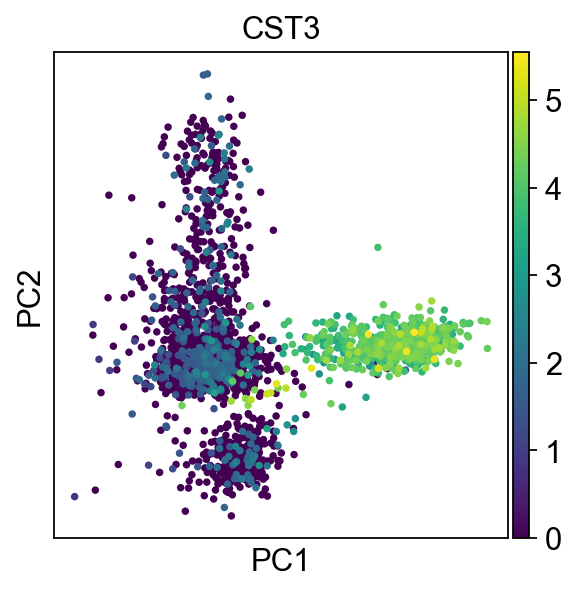

In [ ]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

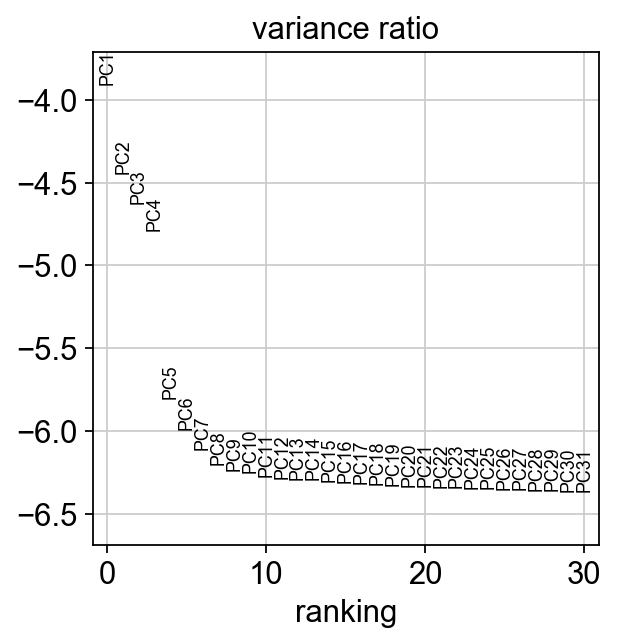

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [ ]:
adata.write(results_file)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


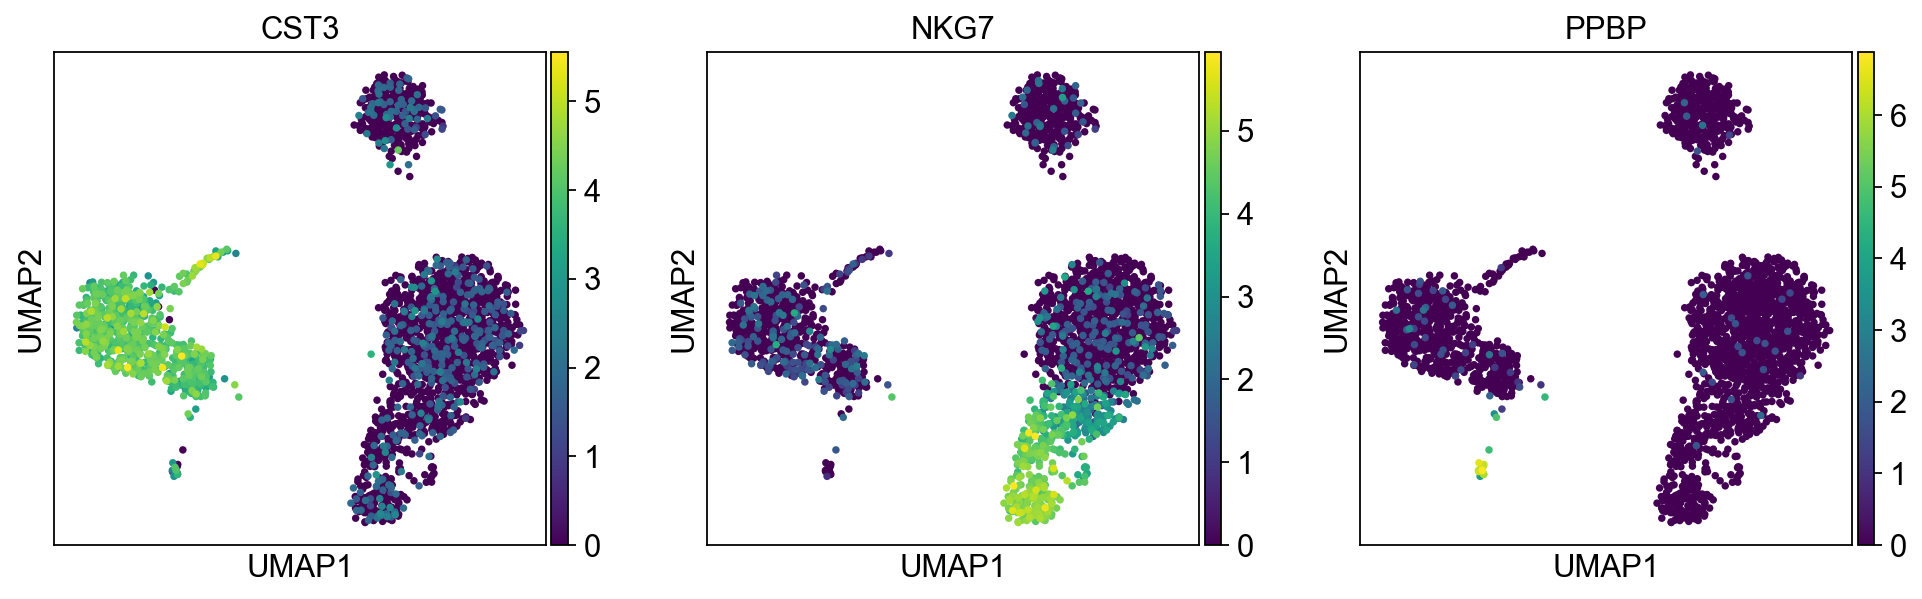

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

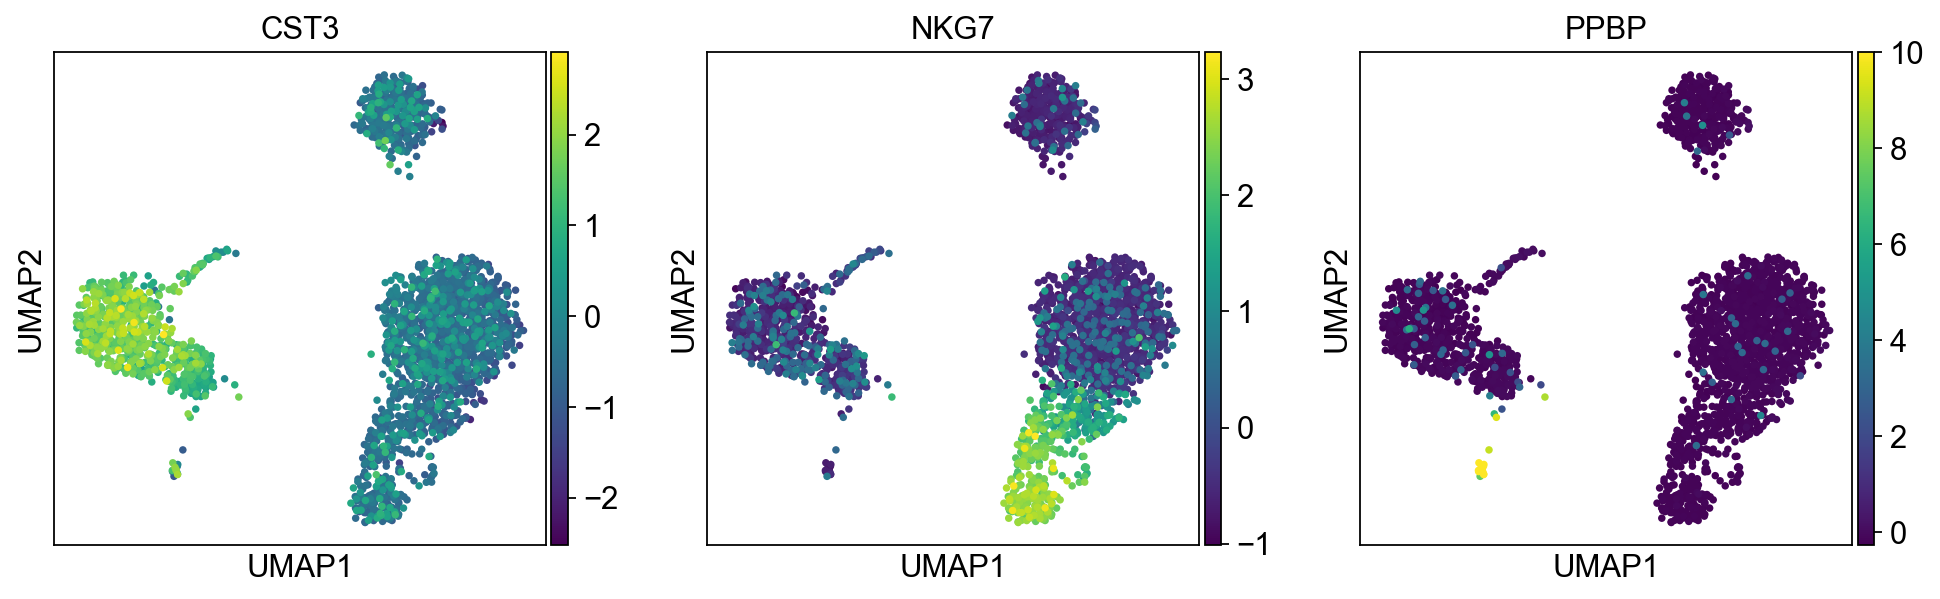

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


Plot the clusters, which agree quite well with the result of Seurat.

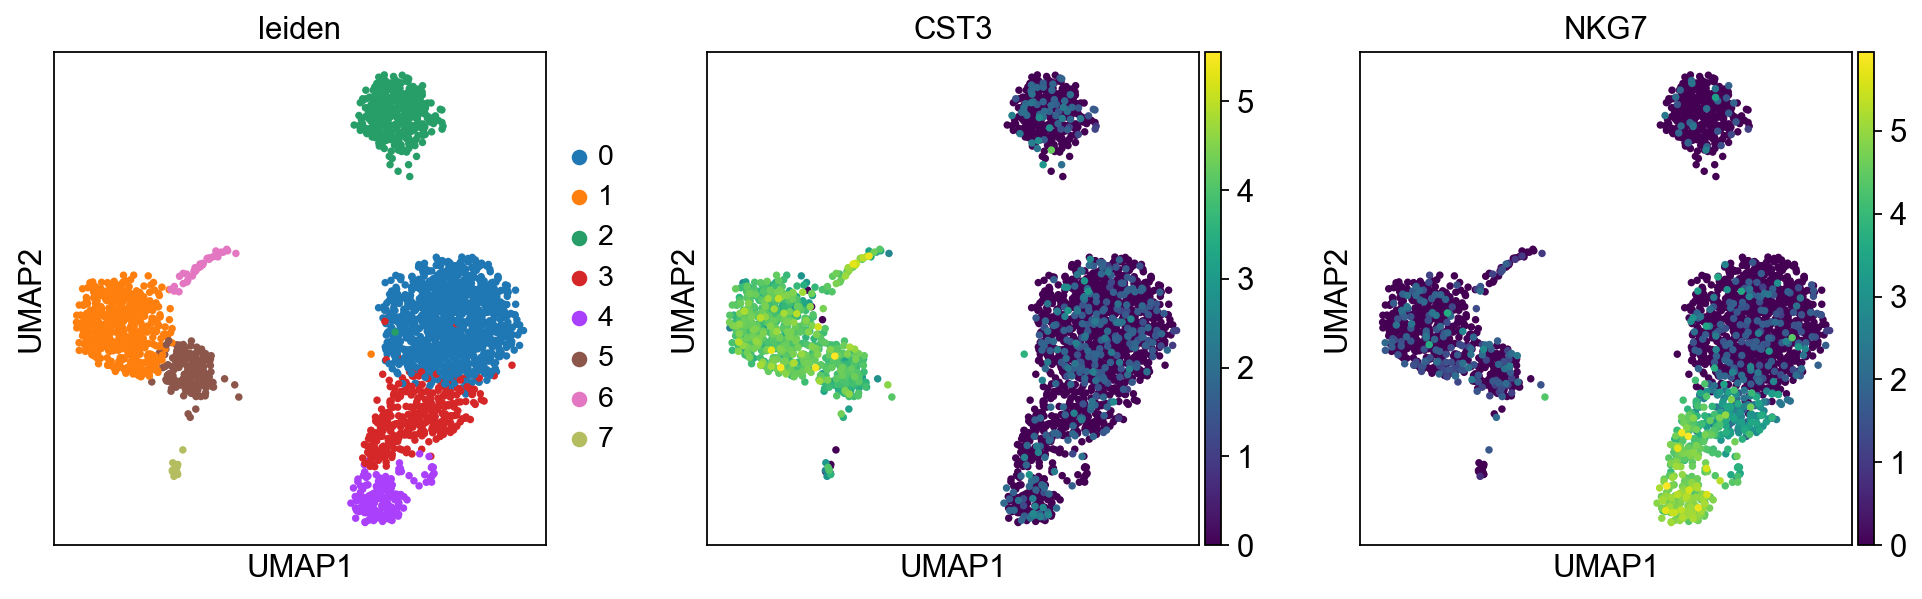

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the result.

In [ ]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


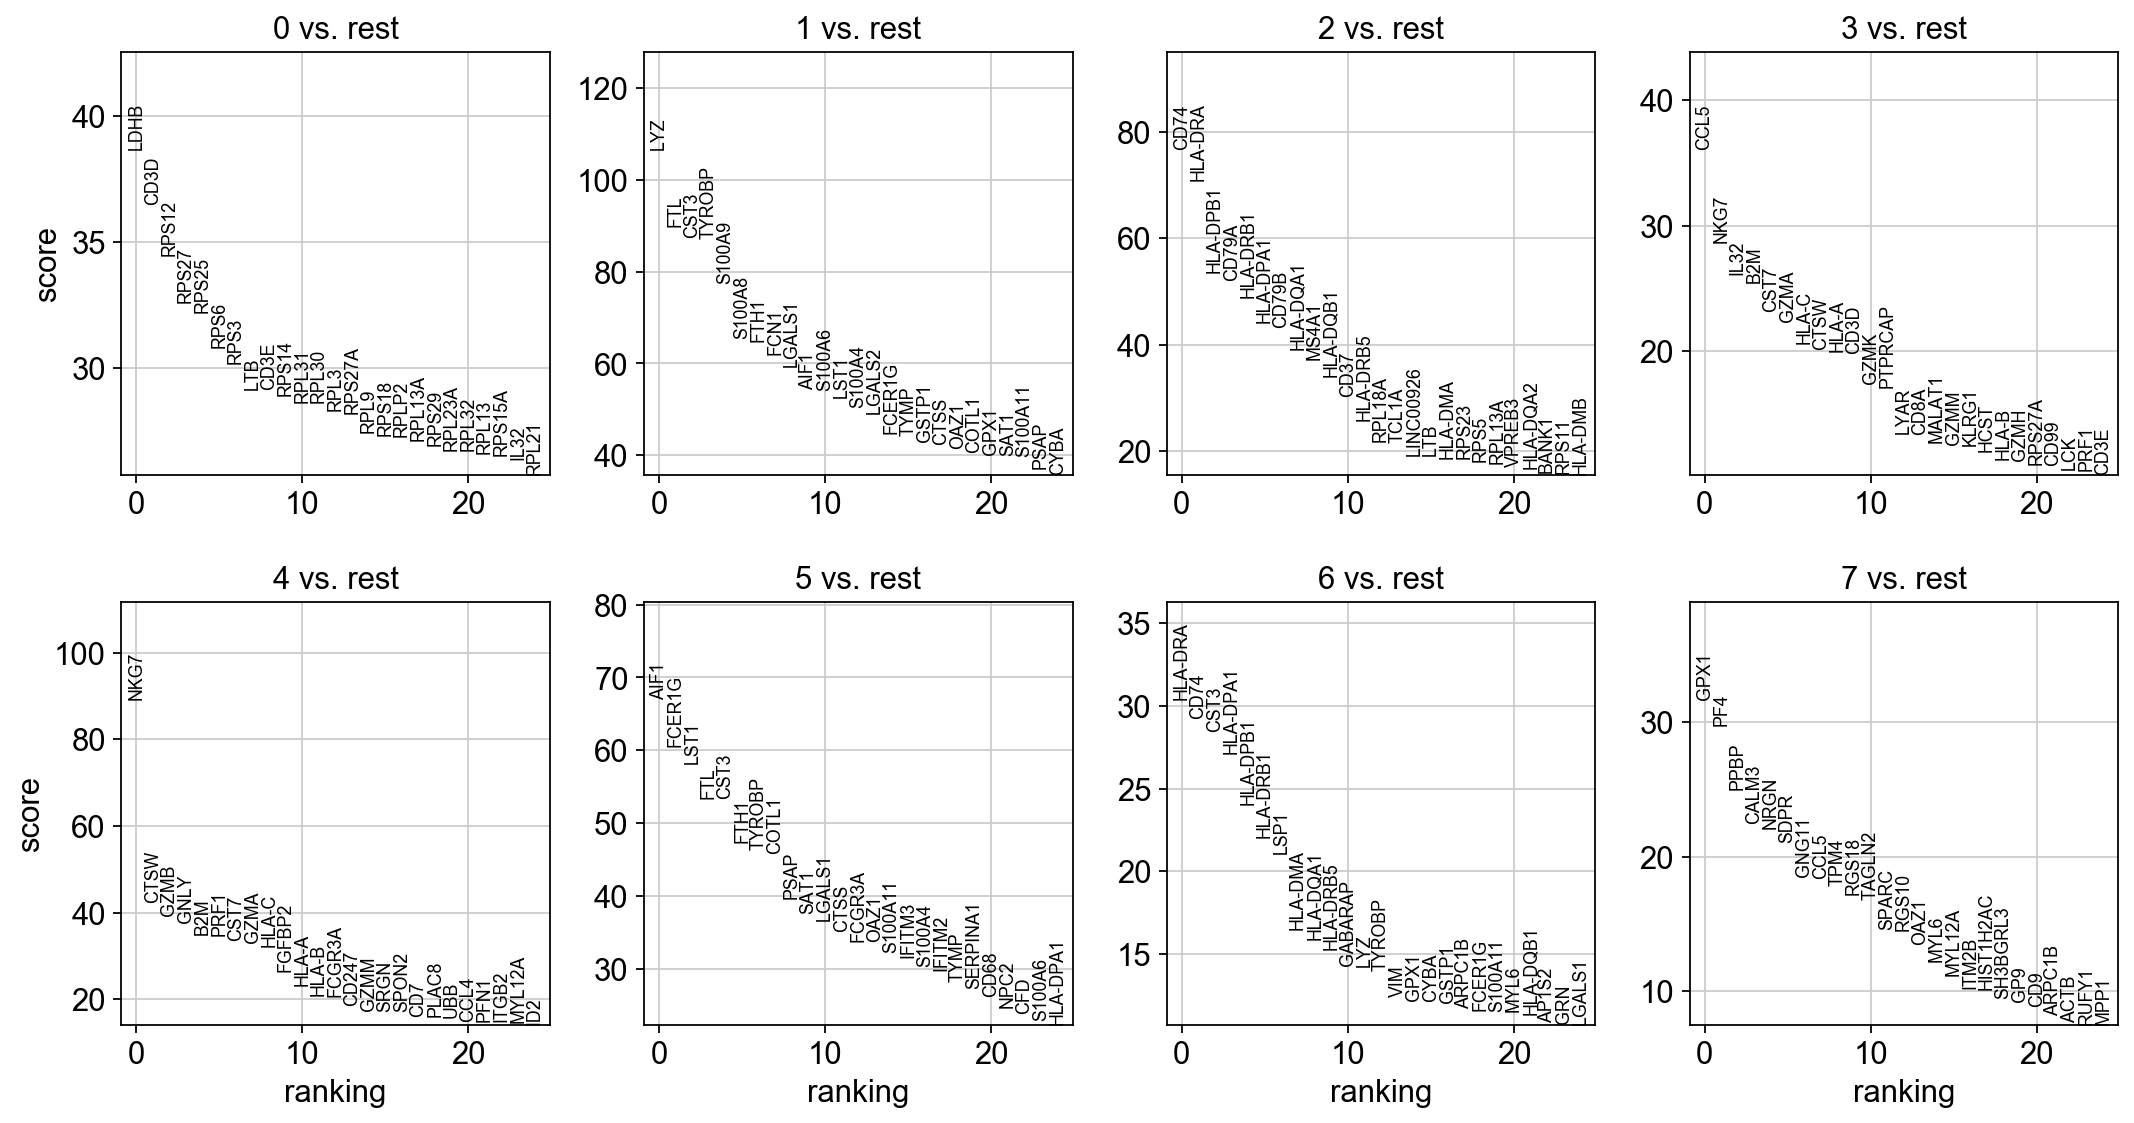

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:02)


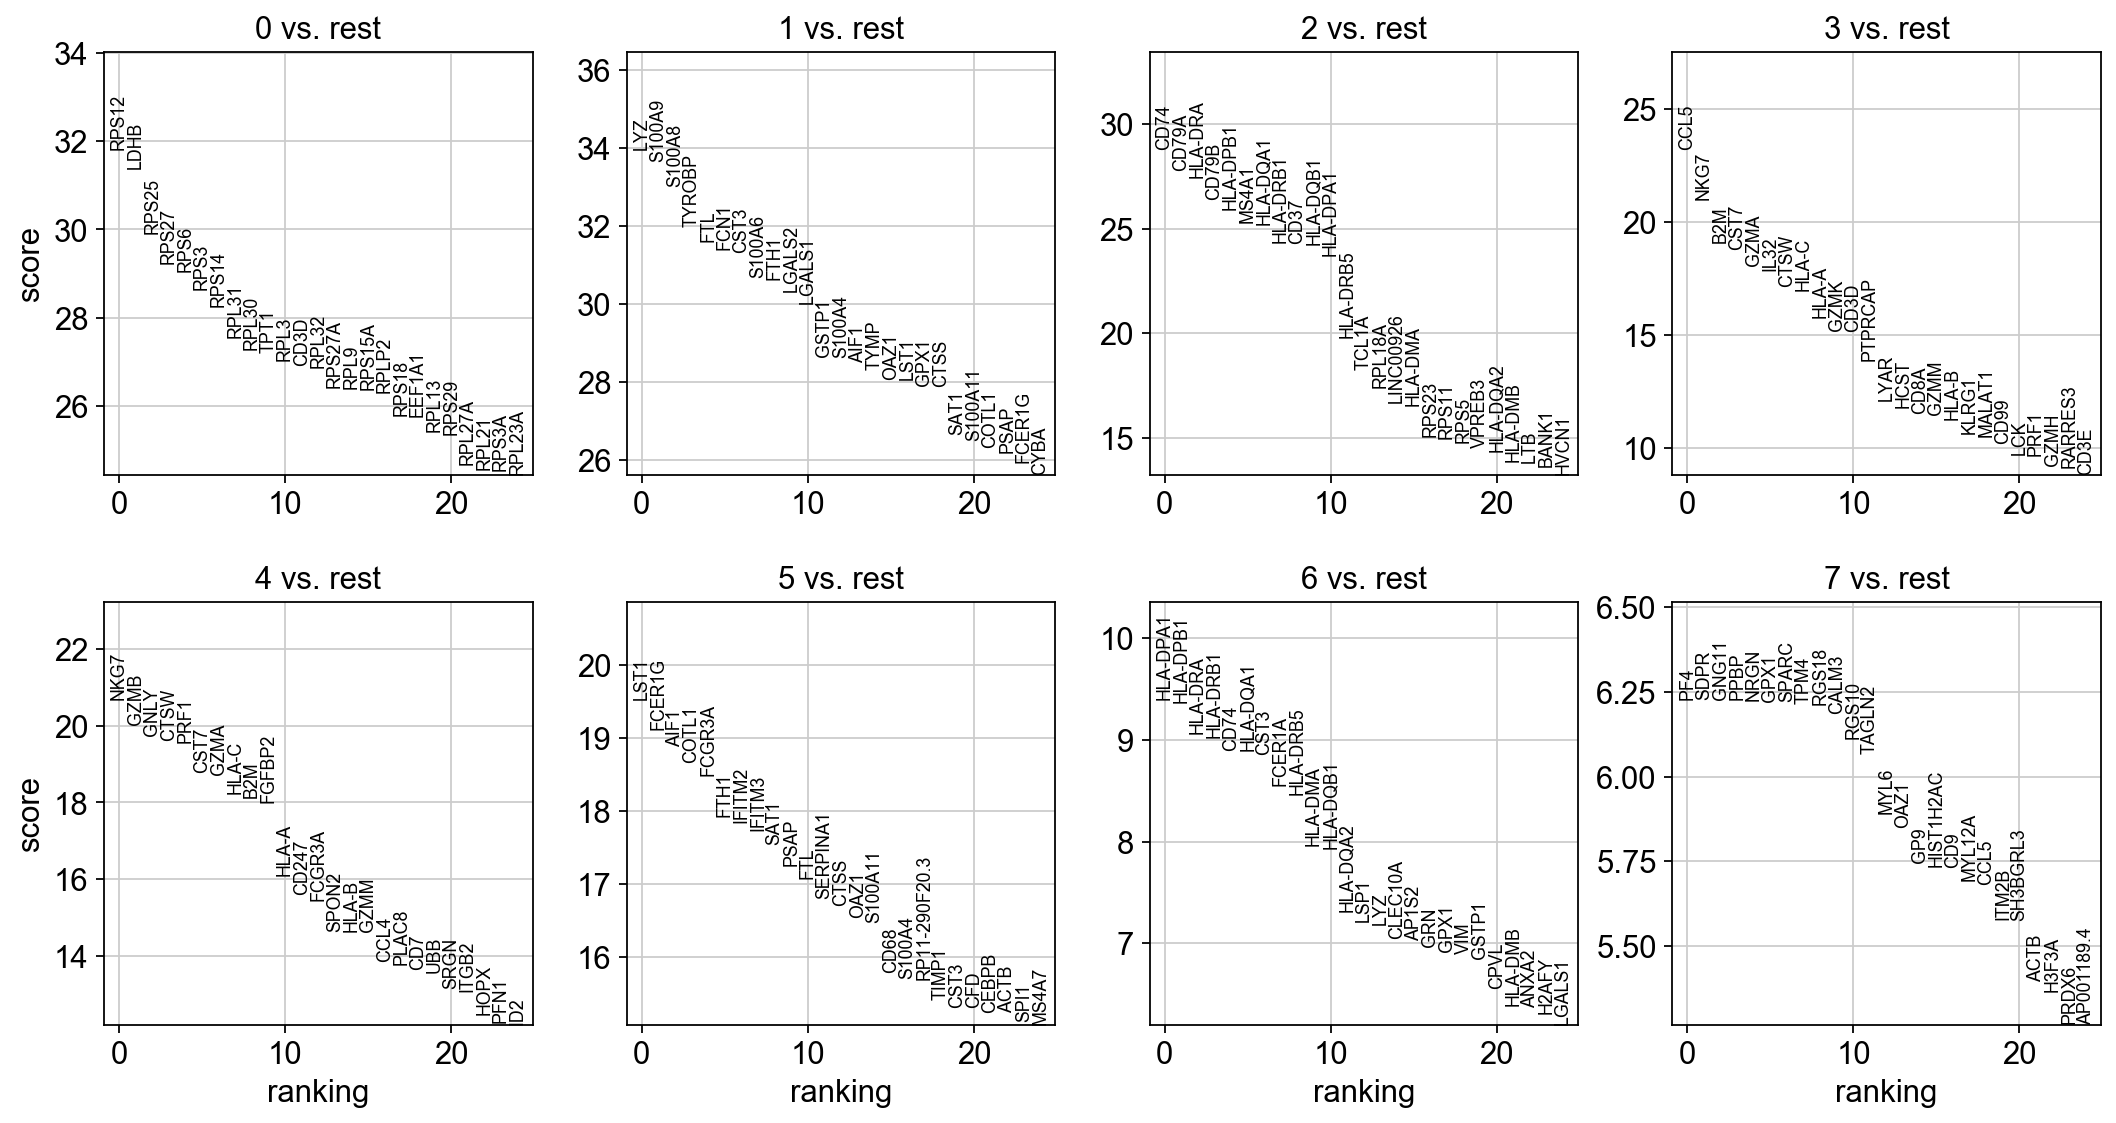

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [ ]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:04)


/Users/alexwolf/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


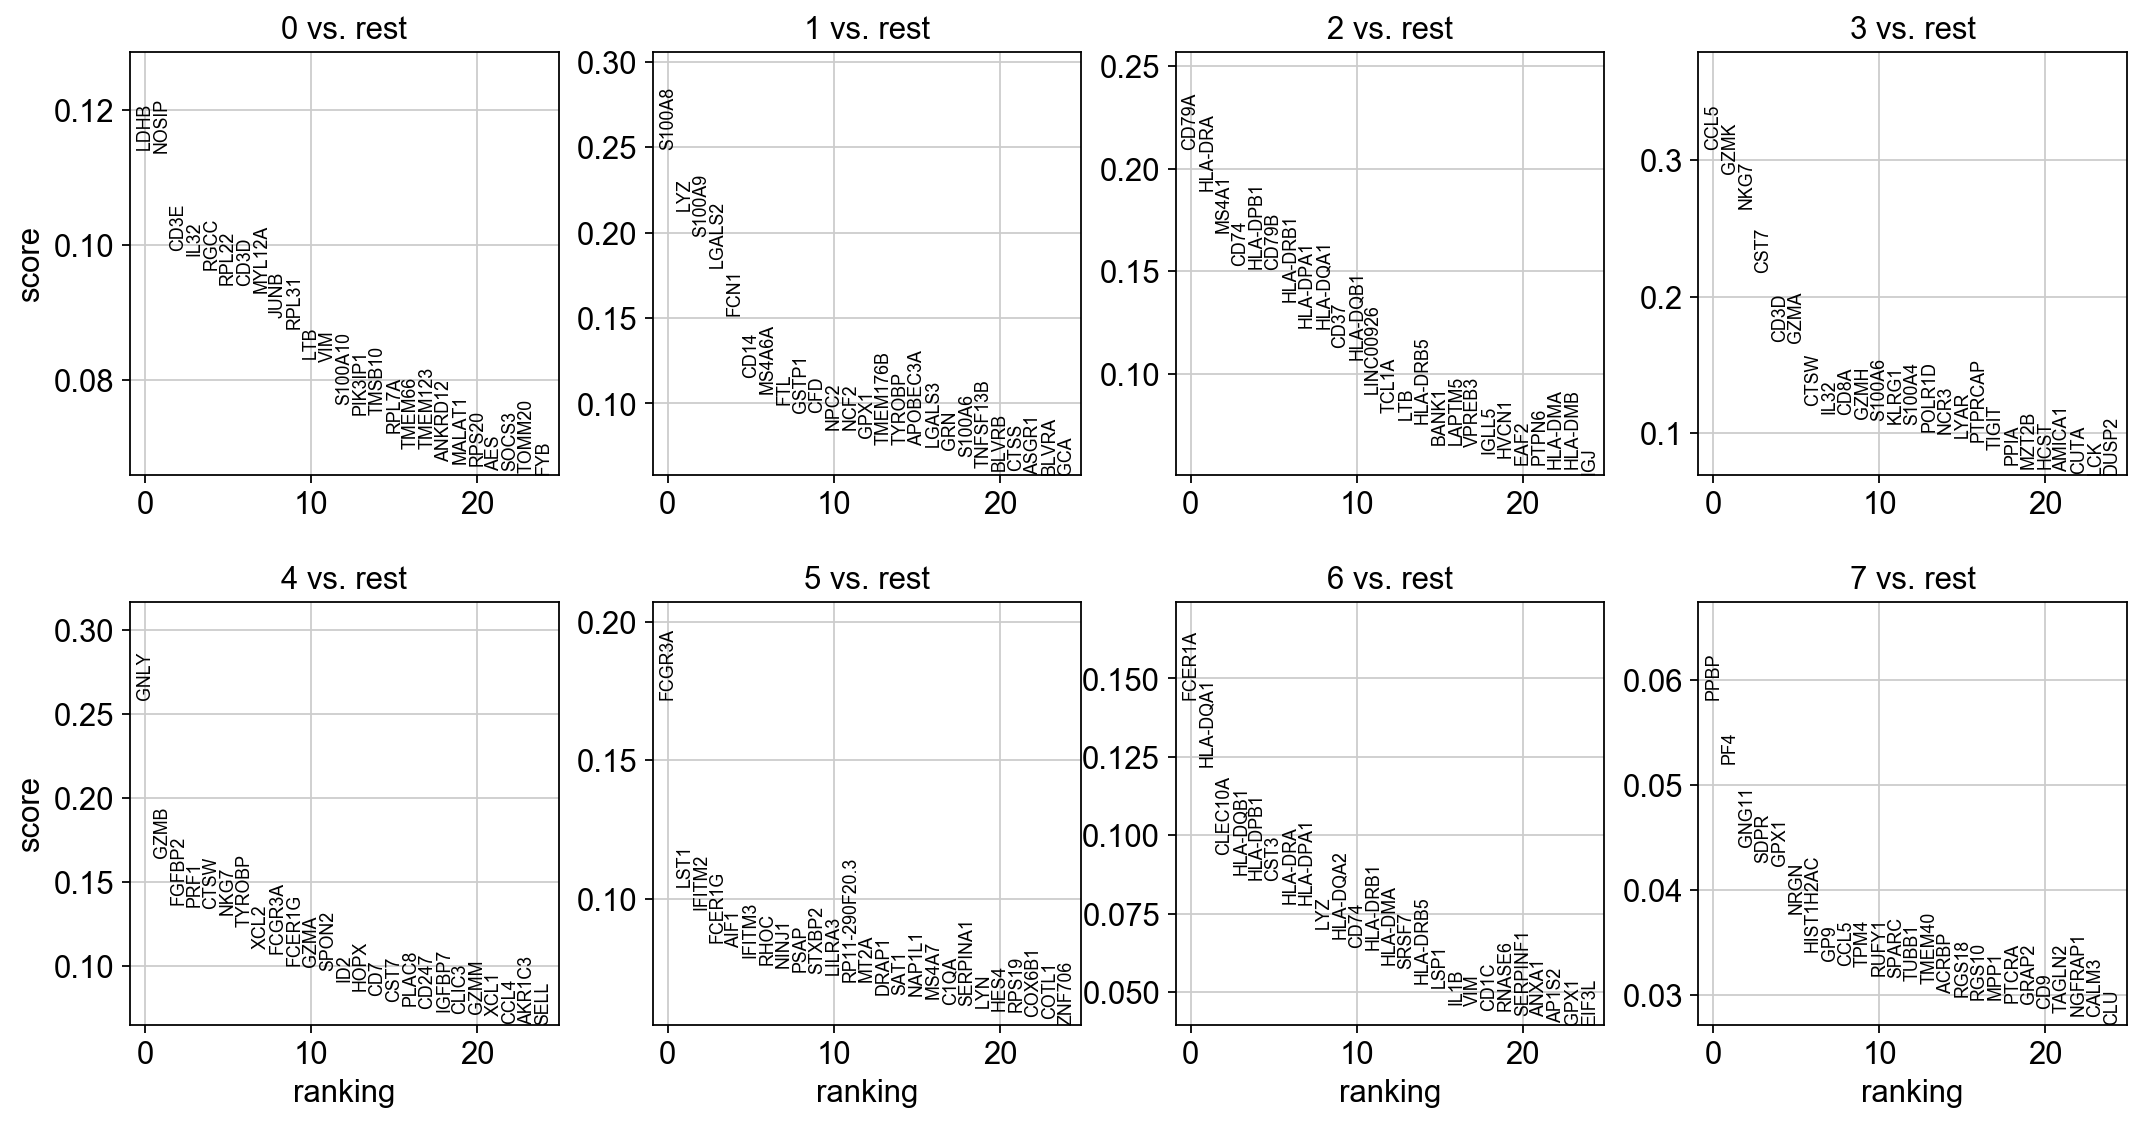

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GZMB  FCER1G  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA   B2M  GNLY    AIF1   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B  CST7  CTSW   COTL1  HLA-DRB1   PPBP
4   RPS6     FTL  HLA-DPB1  GZMA  PRF1  FCGR3A      CD74   NRGN

Get a table with the scores and groups.

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  3.642456e-222     LYZ  1.007060e-252      CD74  3.043536e-182  CCL5   
1   LDHB  3.242464e-216  S100A9  3.664292e-248     CD79A  6.860832e-170  NKG7   
2  RPS25  1.394016e-196  S100A8  9.457377e-239   HLA-DRA  8.398068e-166   B2M   
3  RPS27  9.718451e-188  TYROBP  2.209430e-224     CD79B  1.171444e-153  CST7   
4   RPS6  1.771786e-185     FTL  3.910903e-219  HLA-DPB1  6.167786e-148  GZMA   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  3.896273e-119  NKG7  4.689070e-95    LST1  5.650219e-85  HLA-DPA1   
1   1.170992e-97  GZMB  2.381363e-89  FCER1G  1.697236e-81  HLA-DPB1   
2   3.032705e-81  GNLY  9.322195e-87    AIF1  1.377723e-79   HLA-DRA   
3   1.129293e-78  CTSW  1.035081e-85   COTL1  9.684016e-78  HLA-DRB1   
4   4.263559e-73  PRF1  3.364126e-85  FCGR3A  2.516161e-76      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

Compare to a single cluster: 

ranking genes
    finished (0:00:01)


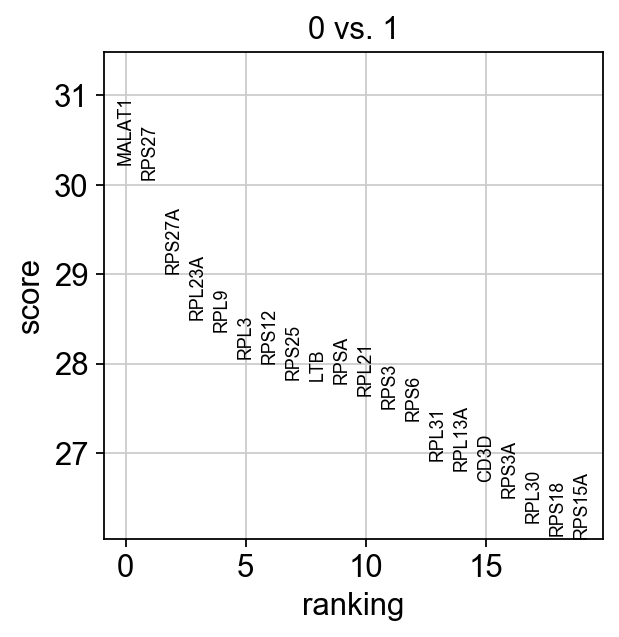

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

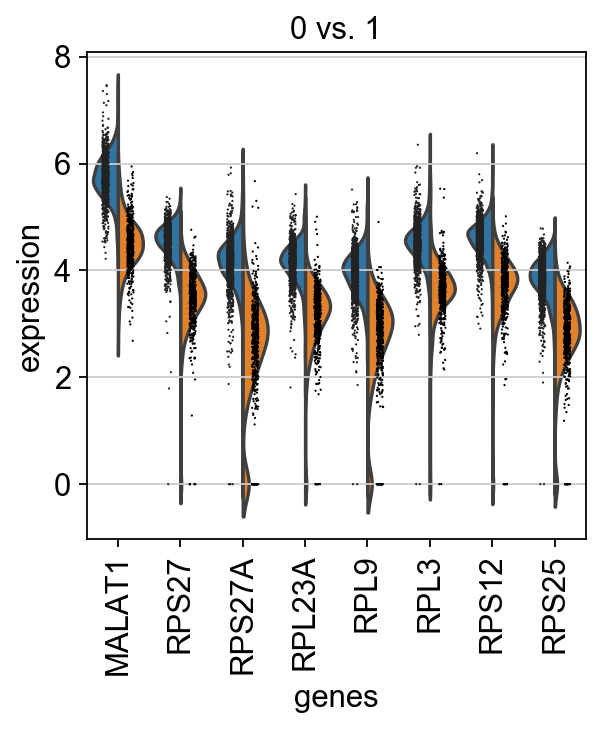

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [ ]:
adata = sc.read(results_file)

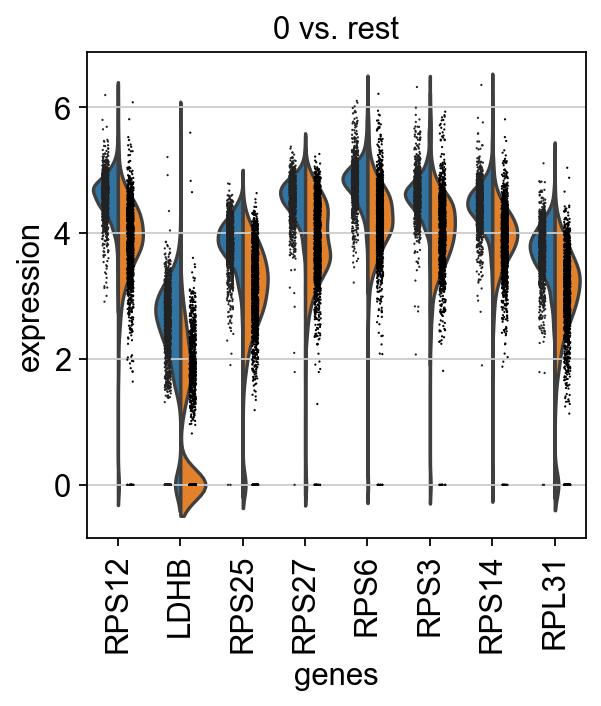

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

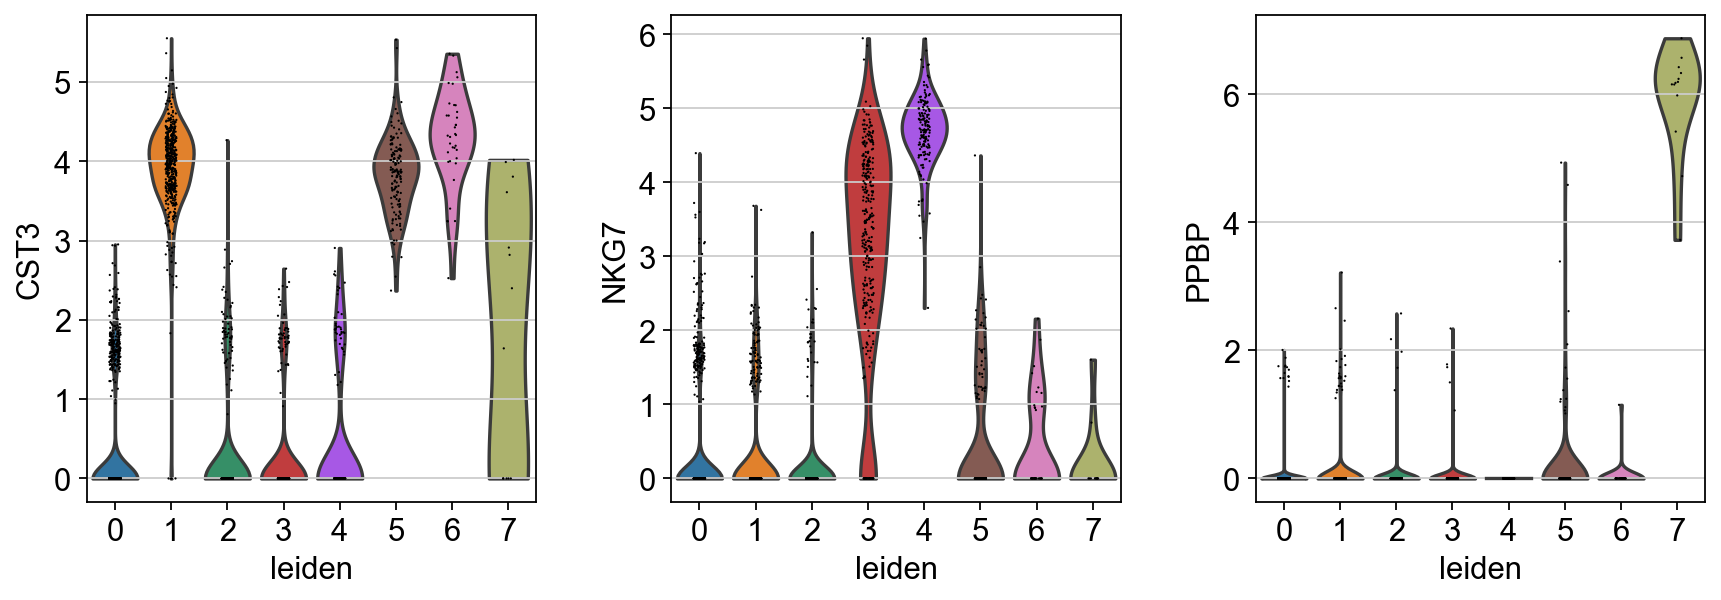

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

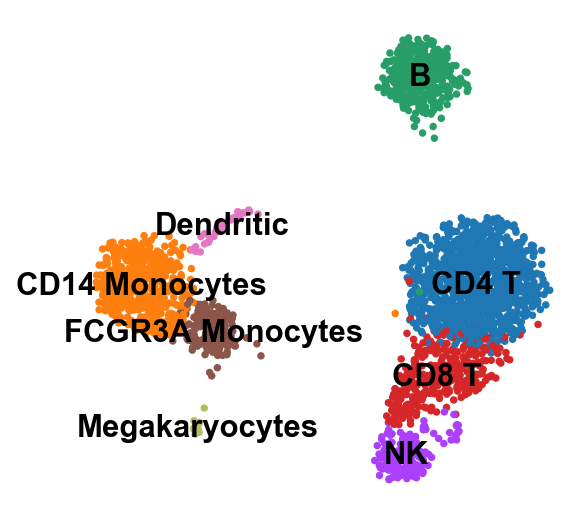

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

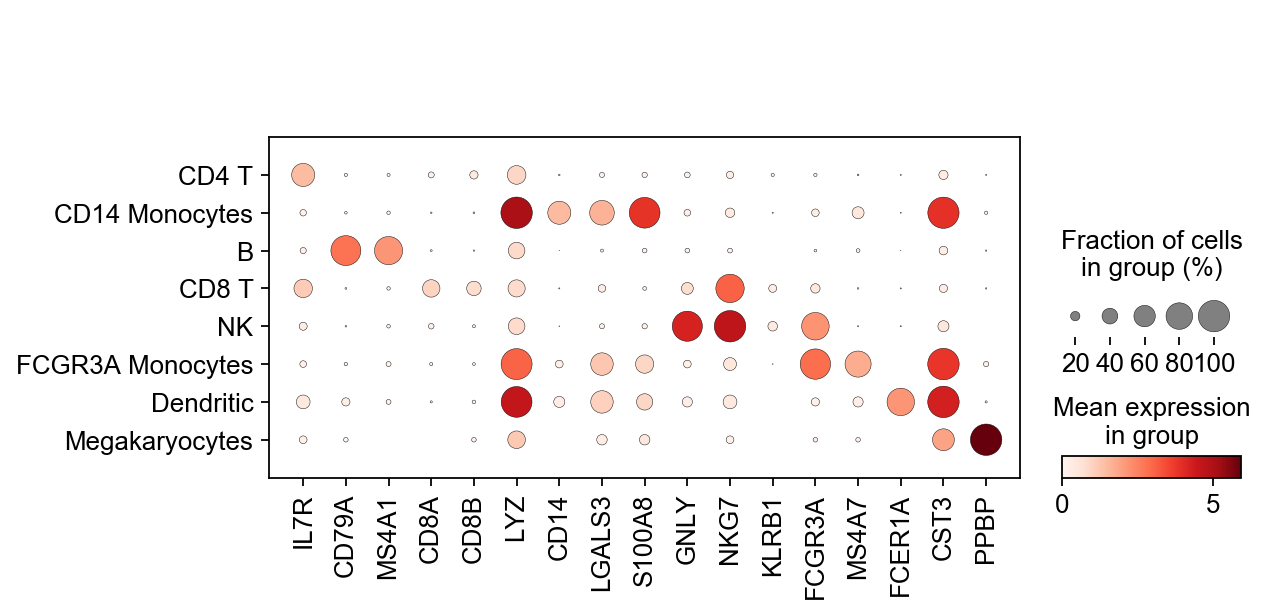

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

There is also a very compact violin plot.

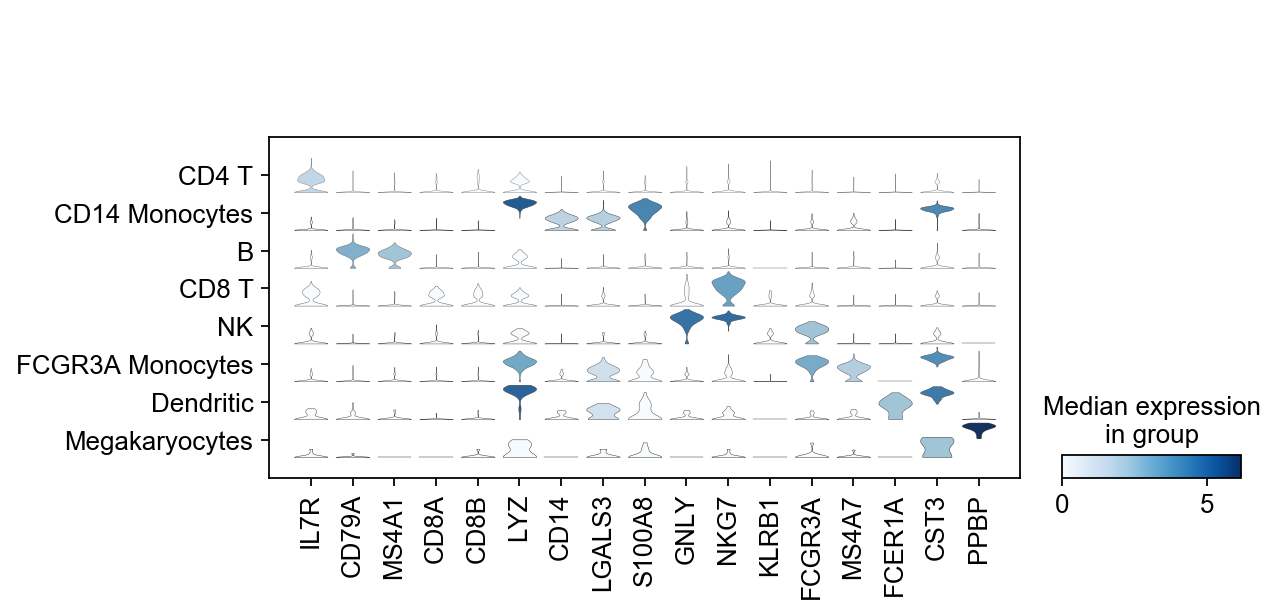

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

During the course of this analysis, the AnnData accumlated the following annotations.

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )